# Introducción

Insideairbnb.com es un sitio web en el que se publican conjuntos de datos extraídos de la web de "instantáneas" de ciudades. He descargado los archivos de Los Ángeles de la situación del 3 de diciembre de 2023. Pensé que era un conjunto de datos divertido para asumir. Además de la disputa de datos básicos y las tramas, también he agregado **mapas interactivos de Folium, gráficos interactivos de tramas y extracción de texto de los comentarios de revisión.**


<br>
<!-- <div style="text-align: center">
    <img src="Captura.PNG" alt="image.png" style="width: 50%;">
</div> -->
<center><img src="que-ver.avif"></center>
<br><br>
<center><img src="Captura.PNG"></center>

# 1. Importando módulos y datos

In [39]:
# !pip install folium
# !pip install branca
# !pip install cufflinks
# !pip install wordcloud

In [40]:
import numpy as np
import pandas as pd
import seaborn as sns
sns.set()
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

import os
import json
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

# mapas interactivos
import folium
from folium.plugins import FastMarkerCluster
import geopandas as gpd
from branca.colormap import LinearColormap

#to make the plotly graphs
import plotly.graph_objs as go
import chart_studio.plotly as py
from plotly.offline import iplot, init_notebook_mode
import plotly.express as px
import cufflinks
cufflinks.go_offline(connected=True)
init_notebook_mode(connected=True)

#text mining
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
import re
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from wordcloud import WordCloud

## 1.2 Detalles del listado de viviendas


In [41]:
print(os.listdir("C:/Users/David\Desktop/upgrade_python/temario_bootcamp/Modulo2/Proyecto-Modulo2/airbnb-los_angeles/datasets"))

['calendar.csv', 'listings.csv', 'listings_details.csv', 'neighbourhoods.csv', 'neighbourhoods.geojson', 'reviews.csv', 'reviews_details.csv']


In [42]:
listings = pd.read_csv("C:/Users/David/Desktop/upgrade_python/temario_bootcamp/Modulo2/Proyecto-Modulo2/airbnb-los_angeles/datasets/listings.csv", index_col= "id")
listings_details = pd.read_csv("C:/Users/David/Desktop/upgrade_python/temario_bootcamp/Modulo2/Proyecto-Modulo2/airbnb-los_angeles/datasets/listings_details.csv", index_col= "id", low_memory=False)

calendar = pd.read_csv("C:/Users/David/Desktop/upgrade_python/temario_bootcamp/Modulo2/Proyecto-Modulo2/airbnb-los_angeles/datasets/calendar.csv", parse_dates=['date'], index_col=['listing_id'])
reviews_details = pd.read_csv("C:/Users/David/Desktop/upgrade_python/temario_bootcamp/Modulo2/Proyecto-Modulo2/airbnb-los_angeles/datasets/reviews_details.csv", parse_dates=['date'])

C:\Users\David\AppData\Local\Temp\ipykernel_34644\1306820951.py:4: DtypeWarning:

Columns (3,4) have mixed types. Specify dtype option on import or set low_memory=False.



In [43]:
print(listings.shape)

(45595, 17)


### El archivo de listados contiene 17 variables por listado además del id.

In [44]:
listings.columns

Index(['name', 'host_id', 'host_name', 'neighbourhood_group', 'neighbourhood',
       'latitude', 'longitude', 'room_type', 'price', 'minimum_nights',
       'number_of_reviews', 'last_review', 'reviews_per_month',
       'calculated_host_listings_count', 'availability_365',
       'number_of_reviews_ltm', 'license'],
      dtype='object')

In [45]:
print(listings_details.shape)

(45591, 74)


### El archivo listados_detalles contiene un total de 74 variables. No vamos a usar todos estos, sino que juntaremos selectivamente una serie de variables que parecen útiles para este EDA.

In [46]:
target_columns = ["property_type", "accommodates", "first_review", "review_scores_value", "review_scores_cleanliness", "review_scores_location", "review_scores_accuracy", "review_scores_communication", "review_scores_checkin", "review_scores_rating", "maximum_nights", "listing_url", "host_is_superhost", "host_about", "host_response_time", "host_response_rate", "neighbourhood", "price", "amenities"]
listings = pd.merge(listings, listings_details[target_columns], on='id', how='left')
listings.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 45595 entries, 109 to 1037702905074810033
Data columns (total 36 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   name                            45595 non-null  object 
 1   host_id                         45595 non-null  int64  
 2   host_name                       45575 non-null  object 
 3   neighbourhood_group             45595 non-null  object 
 4   neighbourhood_x                 45595 non-null  object 
 5   latitude                        45595 non-null  float64
 6   longitude                       45595 non-null  float64
 7   room_type                       45595 non-null  object 
 8   price_x                         45595 non-null  int64  
 9   minimum_nights                  45595 non-null  int64  
 10  number_of_reviews               45595 non-null  int64  
 11  last_review                     32948 non-null  object 
 12  reviews_per_mont

### Vemos el nº total de valores nulos en los 4 datasets

Listings

In [47]:
# Listings
null_values = listings.isnull().sum()
print(null_values[null_values>0])

host_name                         20
last_review                    12647
reviews_per_month              12647
license                        33626
property_type                      4
accommodates                       4
first_review                   12651
review_scores_value            12658
review_scores_cleanliness      12645
review_scores_location         12654
review_scores_accuracy         12644
review_scores_communication    12645
review_scores_checkin          12652
review_scores_rating           12632
maximum_nights                     4
listing_url                        4
host_is_superhost                253
host_about                     20947
host_response_time             10732
host_response_rate             10732
neighbourhood_y                20394
price_y                            4
amenities                          4
dtype: int64


In [48]:
# Imputar 'property_type' con la moda (el valor más frecuente)
property_type_mode = listings['property_type'].mode()[0]
listings['property_type'].fillna(property_type_mode, inplace=True)

# Imputar 'accommodates' con la mediana
accommodates_median = listings['accommodates'].median()
listings['accommodates'].fillna(accommodates_median, inplace=True)

# Imputar 'maximum_nights' con la mediana
maximum_nights_median = listings['maximum_nights'].median()
listings['maximum_nights'].fillna(maximum_nights_median, inplace=True)

# Imputar 'price_y' con la mediana o algún otro valor representativo
# Arreglamos columna price_y
listings['price_y'] = listings['price_y'].replace('[\$,]', '', regex=True).astype(float)
price_y_median = listings['price_y'].median()
listings['price_y'].fillna(price_y_median, inplace=True)

# Imputar 'amenities' con la moda
amenities_mode = listings['amenities'].mode()[0]
listings['amenities'].fillna(amenities_mode, inplace=True)

# Verificar si aún hay valores nulos
null_values_after_imputation = listings[['property_type', 'accommodates', 'maximum_nights', 'price_y', 'amenities']].isnull().sum()
null_values_after_imputation



property_type     0
accommodates      0
maximum_nights    0
price_y           0
amenities         0
dtype: int64

Listings_details

In [49]:
# Listings_details
null_values = listings_details.isnull().sum()
print(null_values[null_values>0])

description                    45591
neighborhood_overview          20391
host_name                         16
host_since                        16
host_location                  11240
host_about                     20943
host_response_time             10728
host_response_rate             10728
host_acceptance_rate            9638
host_is_superhost                249
host_thumbnail_url                16
host_picture_url                  16
host_neighbourhood             10051
host_listings_count               16
host_total_listings_count         16
host_has_profile_pic              16
host_identity_verified            16
neighbourhood                  20390
bathrooms                      45591
bathrooms_text                    35
bedrooms                       45488
beds                             477
calendar_updated               45591
first_review                   12647
last_review                    12647
review_scores_rating           12628
review_scores_accuracy         12640
r

In [50]:
# Calculamos e imputamos con la moda en 'bathrooms_text'
bathrooms_text_mode = listings_details['bathrooms_text'].mode()[0]
listings_details['bathrooms_text'].fillna(bathrooms_text_mode, inplace=True)

# Calculamos e imputamos con la mediana para 'beds'
beds_median = listings_details['beds'].median()
listings_details['beds'].fillna(beds_median, inplace=True)

# Verificar si aún hay valores nulos en estas columnas
null_values_after_imputation = listings_details[['bathrooms_text', 'beds']].isnull().sum()
print(null_values_after_imputation)


bathrooms_text    0
beds              0
dtype: int64


### Calendar

In [51]:
# Calendar
null_values = calendar.isnull().sum()
print(null_values[null_values>0])

price             16606236
adjusted_price    16606236
minimum_nights         803
maximum_nights         803
dtype: int64


In [52]:
# Calcular la moda para 'minimum_nights' y 'maximum_nights'
minimum_nights_mode = calendar['minimum_nights'].mode()[0]
maximum_nights_mode = calendar['maximum_nights'].mode()[0]

# Imputar valores nulos con la moda
calendar['minimum_nights'].fillna(minimum_nights_mode, inplace=True)
calendar['maximum_nights'].fillna(maximum_nights_mode, inplace=True)

# Verificar si aún hay valores nulos
null_values_after = calendar[['minimum_nights', 'maximum_nights']].isnull().sum()
print(null_values_after)

minimum_nights    0
maximum_nights    0
dtype: int64


### Reviews_details

In [53]:
# Reviews_details
null_values = reviews_details.isnull().sum()
print(null_values[null_values>0])

comments    293
dtype: int64


In [54]:
listings.head()

name  host_id  \
id                                                                  
109    Condo in Culver City · 2 bedrooms · 2 beds · 2...      521   
2708   Rental unit in Los Angeles · ★4.85 · 1 bedroom...     3008   
2732   Rental unit in Santa Monica · ★4.41 · 1 bedroo...     3041   
63416  Home in Hollywood · ★4.99 · 1 bedroom · 2 beds...   309512   
2864   Rental unit in Bellflower · 1 bedroom · 1 bed ...     3207   

            host_name  neighbourhood_group  neighbourhood_x  latitude  \
id                                                                      
109             Paolo         Other Cities      Culver City  33.98301   
2708            Chas.  City of Los Angeles        Hollywood  34.09625   
2732   Yoga Priestess         Other Cities     Santa Monica  34.00440   
63416        Vincenzo  City of Los Angeles  Hollywood Hills  34.11344   
2864        Bernadine         Other Cities       Bellflower  33.87490   

       longitude        room_type  price_x  minimum_nights  ...  \
id                                                          ...   
109   -118.38607  Entire home/apt      129              30  ...   
2708  -118.34605     Private room       94              30  ...   
2732  -118.48095     Private room      179               7  ...   
63416 -118.32399     Private room      220               2  ...   
2864  -118.11515  Entire home/apt       50              30  ...   

       review_scores_rating maximum_nights  \
id                                           
109                    4.00          730.0   
2708                   4.85          550.0   
2732                   4.41           27.0   
63416                  4.99          365.0   
2864                    NaN          730.0   

                              listing_url  host_is_superhost  \
id                                                             
109      https://www.airbnb.com/rooms/109                  f   
2708    https://www.airbnb.com/rooms/2708                  t   
2732    https://www.airbnb.com/rooms/2732                  f   
63416  https://www.airbnb.com/rooms/63416                  t   
2864    https://www.airbnb.com/rooms/2864                  f   

                                              host_about  host_response_time  \
id                                                                             
109    Paolo Privitera, CEO Evensi\n\nPaolo, MIT MBA ...                 NaN   
2708   Professional and technical writer.\nLiterary C...                 NaN   
2732   I have been teaching yoga and meditation for 3...      within an hour   
63416  Check out my listing on Airbnb to learn more a...      within an hour   
2864   Fair, open, honest and very informative for ne...                 NaN   

      host_response_rate                          neighbourhood_y  price_y  \
id                                                                           
109                  NaN                                      NaN    129.0   
2708                 NaN   Los Angeles, California, United States     94.0   
2732                100%  Santa Monica, California, United States    179.0   
63416               100%                                      NaN    220.0   
2864                 NaN    Bellflower, California, United States     50.0   

                                               amenities  
id                                                        
109    ["Private patio or balcony", "Shared pool", "E...  
2708   ["Wen, V05, Prell, among others.  conditioner"...  
2732   ["Private patio or balcony", "Hair dryer", "De...  
63416  ["Shampoo", "Kitchen", "Hot water kettle", "Ir...  
2864   ["TV", "Iron", "Essentials", "Carbon monoxide ...  

[5 rows x 36 columns]

# 2. Análisis exploratorio
## 2.1 Vecindario


In [55]:
filtered_listings = listings[listings['neighbourhood_group'] == 'City of Los Angeles']

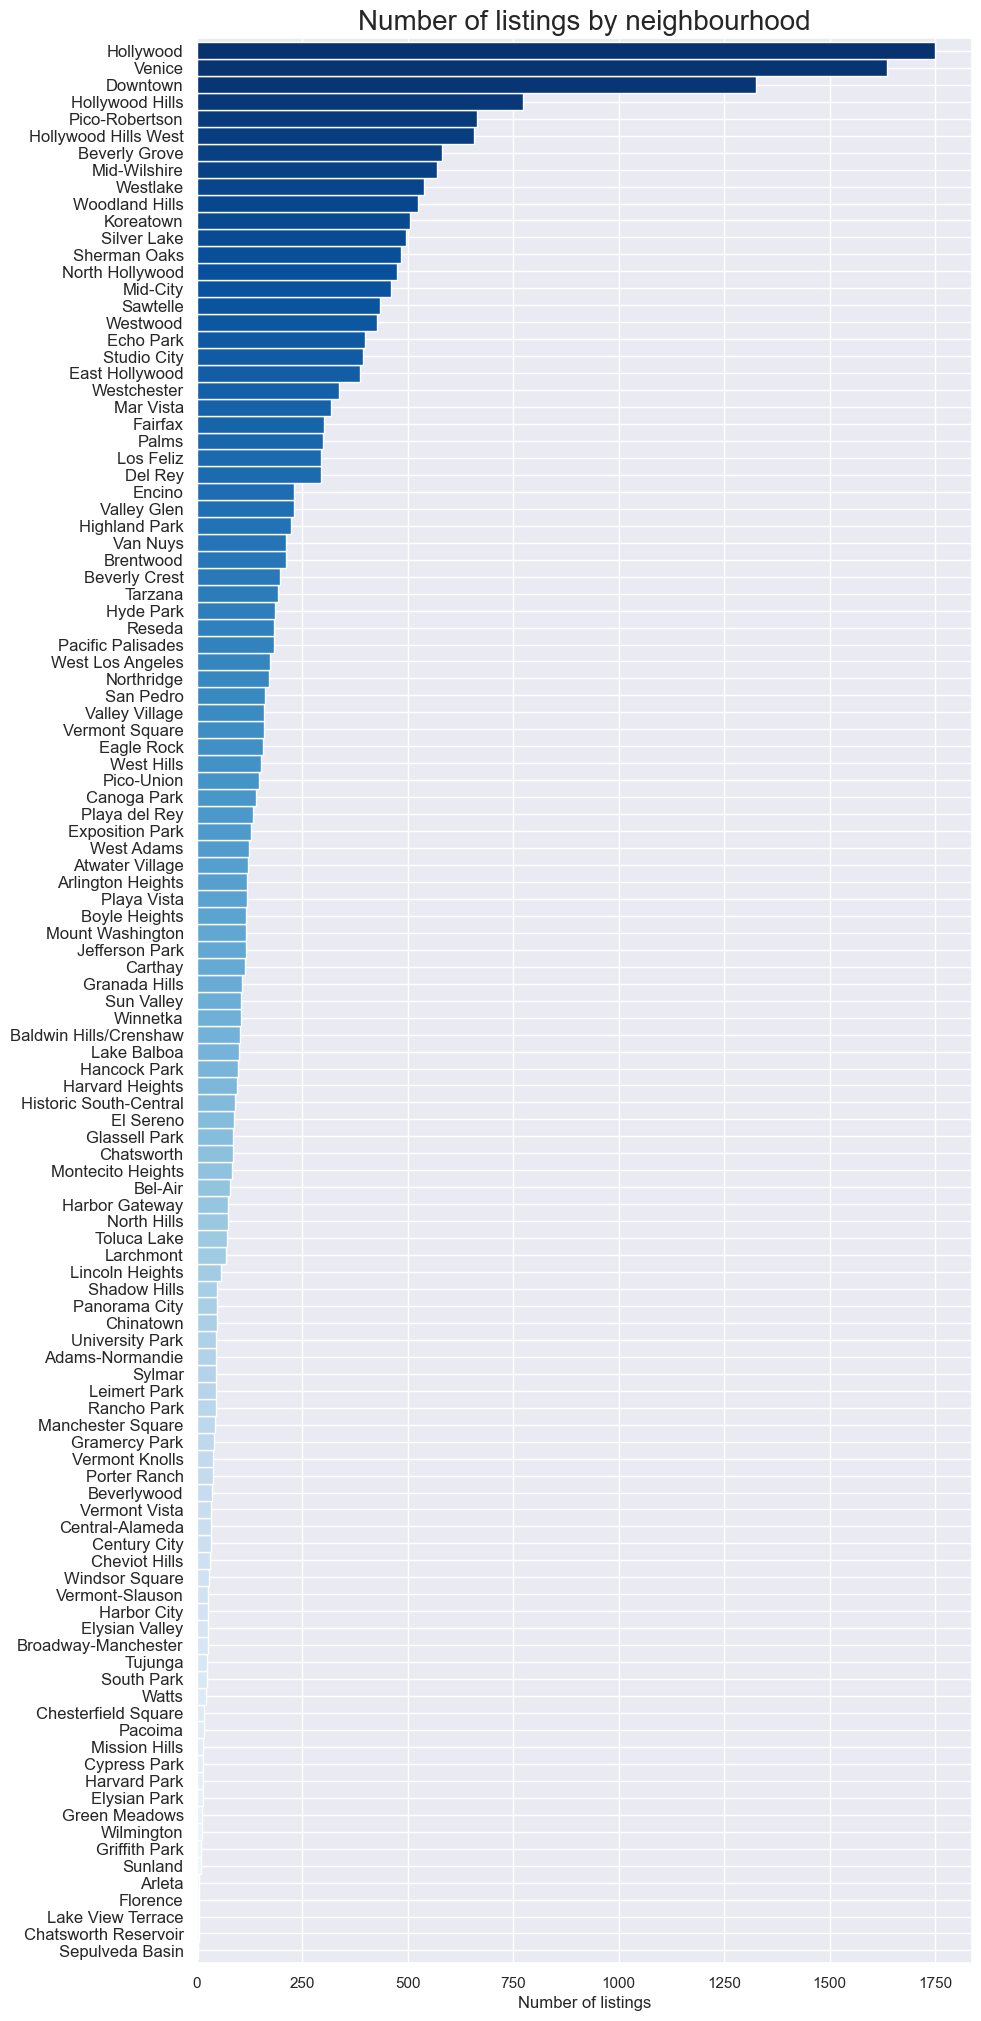

In [57]:
feq=filtered_listings['neighbourhood_x'].value_counts().sort_values(ascending=True)

# Generar una lista de colores usando una paleta de Seaborn, donde la longitud es igual al número de barras
colors = sns.color_palette('Blues', len(feq))

# Crear el gráfico de barras horizontal con los colores generados
feq.plot.barh(figsize=(10, 25),width=1, color=colors)

plt.title("Number of listings by neighbourhood", fontsize=20)
plt.xlabel('Number of listings', fontsize=12)
plt.tick_params(axis='y', which='major', labelsize=12)
plt.show()

A continuación, creamos un mapa interactivo donde podemos ampliar los grupos para encontrar las ubicaciones individuales de los listados.

Nota: En una versión posterior hice un mapa sobre el precio promedio diario por barrio (sección 4.1). Creo que este mapa también sería mejor en este punto (ya que usa el archivo de forma del vecindario), pero como mi objetivo principal de este kernel es aprender tanto como sea posible, dejé el mapa a continuación sin cambios, ya que FastMarkerCluster parece útil para el futuro.

In [58]:
lats2023 = filtered_listings['latitude'].tolist()
lons2023 = filtered_listings['longitude'].tolist()
locations = list(zip(lats2023, lons2023))

map1 = folium.Map(location=[34.0522, -118.2437], zoom_start=11.5)
FastMarkerCluster(data=locations).add_to(map1)
map1

## 2.2 Tipos de propiedades y habitaciones

### 2.2.1 Tipos de habitaciones

El tipo de habitación es muy importante en Los Ángeles, porque en Los Ángeles se implementaron regulaciones para alquileres a corto plazo que entraron en vigor en julio de 2019. Estas regulaciones estipulan que los anfitriones solo pueden alquilar su residencia principal en plataformas de alquiler a corto plazo como Airbnb por hasta 120 días al año.
A continuación, podemos ver que esta restricción se aplica a la mayoría de los listados.

In [59]:
# Filtrar el DataFrame para excluir filas donde 'room_type' es 'Hotel room'
filtered_listings = filtered_listings[filtered_listings['room_type'] != 'Hotel room']


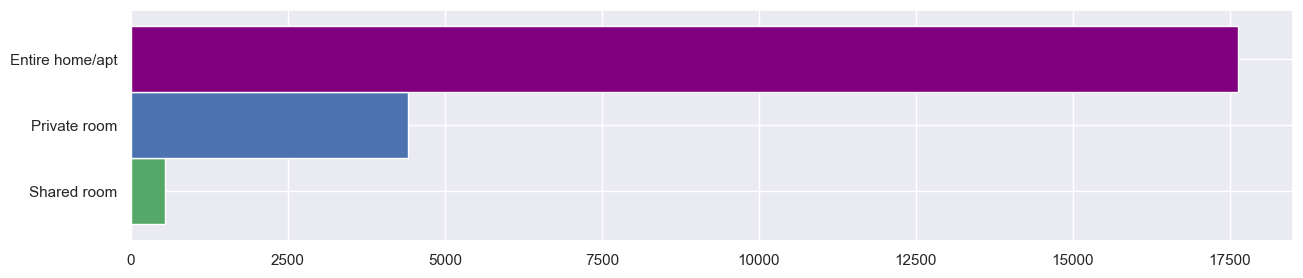

In [60]:
freq = filtered_listings['room_type']. value_counts().sort_values(ascending=True)
freq.plot.barh(figsize=(15, 3), width=1, color = ["g","b","purple"])

plt.show()

### 2.2.2 Tipos de propiedades

En el conjunto de datos, encontramos muchos tipos de propiedades diferentes.

In [61]:
filtered_listings.property_type.unique()

array(['Private room in rental unit', 'Private room in home',
       'Private room in tiny home', 'Entire bungalow',
       'Entire guesthouse', 'Entire rental unit', 'Entire home',
       'Entire vacation home', 'Entire guest suite', 'Entire townhouse',
       'Private room in hostel', 'Room in hotel', 'Entire condo',
       'Private room in condo', 'Farm stay', 'Entire loft',
       'Private room in bungalow', 'Shared room in hostel',
       'Shared room in home', 'Private room in loft', 'Entire cottage',
       'Shared room in villa', 'Private room in townhouse',
       'Private room in guest suite', 'Entire villa',
       'Room in aparthotel', 'Treehouse', 'Entire cabin',
       'Private room in guesthouse', 'Shared room in rental unit',
       'Private room in cottage', 'Room in boutique hotel',
       'Private room in bed and breakfast', 'Yurt',
       'Private room in treehouse', 'Entire place',
       'Entire serviced apartment', 'Tiny home', 'Private room',
       'Private roo

Sin embargo, muchos de esos tipos de propiedades tienen muy pocos listados en Los Ángeles. En la figura a continuación, solo mostramos tipos de propiedades con al menos 100 listados. Como podemos ver, la gran mayoría de las propiedades en Los Ángeles son unidades de alquiler completa.

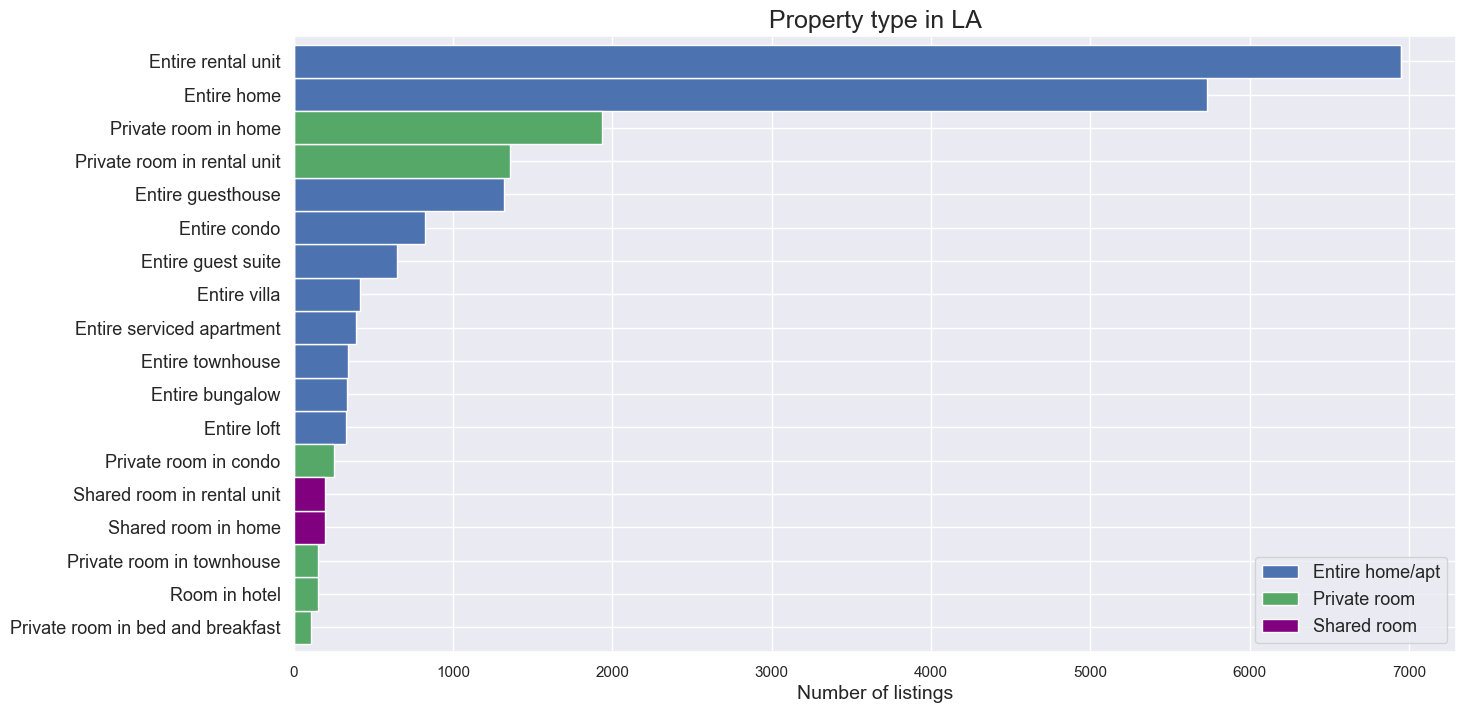

In [63]:
prop = filtered_listings.groupby(['property_type','room_type']).room_type.count()
prop = prop.unstack()
prop['total'] = prop.iloc[:,0:3].sum(axis = 1)
prop = prop.sort_values(by=['total'])
prop = prop[prop['total']>=100]
prop = prop.drop(columns=['total'])

prop.plot(kind='barh',stacked=True, color = ["b","g","purple"],
              linewidth = 1, grid=True, figsize=(15,8), width=1)
plt.title('Property type in LA', fontsize=18)
plt.xlabel('Number of listings', fontsize=14)
plt.ylabel("")
plt.legend(loc = 4,prop = {"size" : 13})
plt.rc('ytick', labelsize=13)
plt.show()

## 2.3 Número de alojados

Como era de esperar, la mayoría de los listados son para 2 personas. Además, Airbnb utiliza un máximo de 16 huéspedes por anuncio.

In [64]:
# Primero reemplazamos los NaN por 0 y luego convertimos la columna a enteros
filtered_listings['accommodates'] = filtered_listings['accommodates'].fillna(0).astype(int)

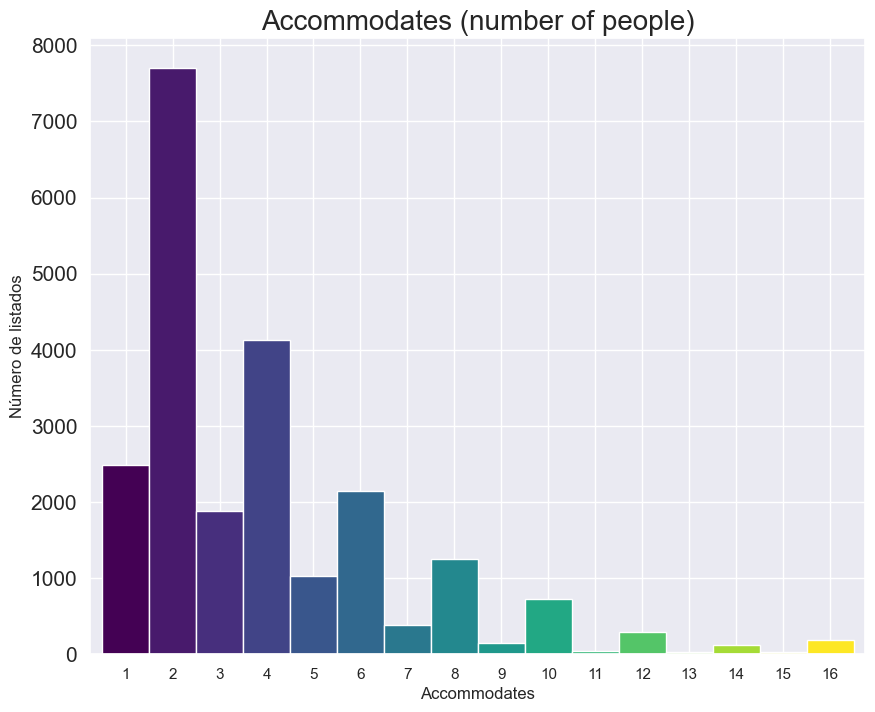

In [65]:
feq=filtered_listings['accommodates'].value_counts().sort_index()
palette = plt.cm.get_cmap('viridis', len(feq))
feq.plot.bar(figsize=(10, 8), color=[palette(i) for i in range(len(feq))], width=1, rot=0)
plt.title("Accommodates (number of people)", fontsize=20)
plt.ylabel('Número de listados', fontsize=12)
plt.xlabel('Accommodates', fontsize=12)
plt.tick_params(axis='y', which='major', labelsize=15)
plt.show()

Aunque no hay una restricción específica en Los Ángeles sobre el número máximo de personas que pueden alojarse en una propiedad de Airbnb, los anfitriones deben cumplir con las regulaciones locales de seguridad, como las relacionadas con el riesgo de incendio y la capacidad máxima. Esto significa que, aunque una propiedad puede listar una capacidad alta, debe hacerlo dentro de los límites de lo que es seguro y permitido por las regulaciones locales.

# 3. Analítica al servicio del gobierno

En Los Ángeles, las regulaciones para alquileres a corto plazo como Airbnb se han implementado para abordar varios problemas, incluyendo la preservación del stock de viviendas y el impacto en los vecindarios. Aquí tenemos varias restricciones:

* Restricciones de alquiler a corto plazo [Short-term rental restrictions](https://www.topangaproperties.com/navigating-airbnb-regulations-in-los-angeles-2023-promoting-safety-neighborliness-and-compliance/): Los Ángeles limita el alquiler de propiedades a corto plazo a 120 días al año. Esta regla está diseñada para prevenir que las viviendas sean usadas exclusivamente para alquileres a corto plazo, lo que podría disminuir la disponibilidad de viviendas para residentes a largo plazo​.

* Registro de propiedades [Property registration requirements](https://www.topangaproperties.com/navigating-airbnb-regulations-in-los-angeles-2023-promoting-safety-neighborliness-and-compliance/): Los anfitriones deben registrar su propiedad con la ciudad y obtener un número de registro de Home Sharing. Este proceso implica proporcionar prueba de residencia, acordar seguir las pautas de la ciudad y pagar una tarifa anual. Además, deben obtener un certificado de registro de impuestos de ocupación transitoria (TOT).

* Restricción a la residencia principal [Primary residence requirement](https://www.topangaproperties.com/navigating-airbnb-regulations-in-los-angeles-2023-promoting-safety-neighborliness-and-compliance/): Los anfitriones solo pueden listar su residencia principal, no propiedades secundarias o casas de inversión. Esta regla ayuda a mantener la disponibilidad de opciones de vivienda a largo plazo para los residentes locales.

* Impacto en el mercado de viviendas [Impact on the housing market](https://cepr.org/voxeu/columns/short-term-rentals-and-housing-market-quasi-experimental-evidence-airbnb-los-angeles): Un estudio en Los Ángeles encontró que Airbnb ha llevado a un aumento en los precios de las viviendas, especialmente en áreas turísticas populares. Las regulaciones como las ordenanzas de Home Sharing (HSO) han demostrado ser efectivas en reducir los alquileres a corto plazo, lo que podría tener un impacto en los precios de las viviendas y los alquileres​. 

>Estas regulaciones en Los Ángeles reflejan un enfoque equilibrado entre permitir los alquileres a corto plazo y proteger las necesidades de vivienda de los residentes permanentes, así como mantener la calidad de vida en los vecindarios. No existen restricciones específicas en cuanto al número máximo de huéspedes o a la prohibición completa de Airbnb en ciertos barrios, pero las reglas se enfocan más en la preservación del stock de viviendas y la mitigación del impacto en los vecindarios.

## 3.1 Análisis del cumplimiento de regulaciones

Filtramos y mostramos las propiedades de Airbnb en Los Ángeles que no tienen un número de licencia registrado.

In [66]:
# Comprobamos propiedades no registradas
unregistered = filtered_listings[filtered_listings['license'].isnull()]

columns_to_print = ['id', 'name', 'host_id']
columns_available = [col for col in columns_to_print if col in listings.columns]

print("Propiedades no registradas:")
unregistered[columns_available]

Propiedades no registradas:


name  \
id                                                                       
2708                 Rental unit in Los Angeles · ★4.85 · 1 bedroom...   
6033                 Bungalow in Woodland Hills · ★4.38 · 1 bedroom...   
6931                 Rental unit in Los Angeles · ★4.83 · 1 bedroom...   
9376                 Rental unit in Los Angeles · ★4.70 · 1 bedroom...   
10760                Rental unit in Los Angeles · ★4.97 · 1 bedroom...   
...                                                                ...   
1036423599733632374  Home in Los Angeles · ★New · 7 bedrooms · 8 be...   
1037208555419214283  Rental unit in West Hollywood · ★New · 1 bedro...   
1036434193608533658  Home in Los Angeles · ★New · 3 bedrooms · 4 be...   
1036456959968739992  Home in Los Angeles · ★New · 1 bedroom · 1 bed...   
1037218883738754729  Home in Los Angeles · ★New · 1 bedroom · 1 bed...   

                       host_id  
id                              
2708                      3008  
6033                     11619  
6931                      3008  
9376                     30319  
10760                    38596  
...                        ...  
1036423599733632374  215263603  
1037208555419214283  137656238  
1036434193608533658   33694089  
1036456959968739992  136683217  
1037218883738754729  534573500  

[13524 rows x 2 columns]

Observamos que este listado es útil para identificar casos individuales de posibles incumplimientos de las regulaciones, lo que es importante para la gestión y control del mercado de alquileres a corto plazo.

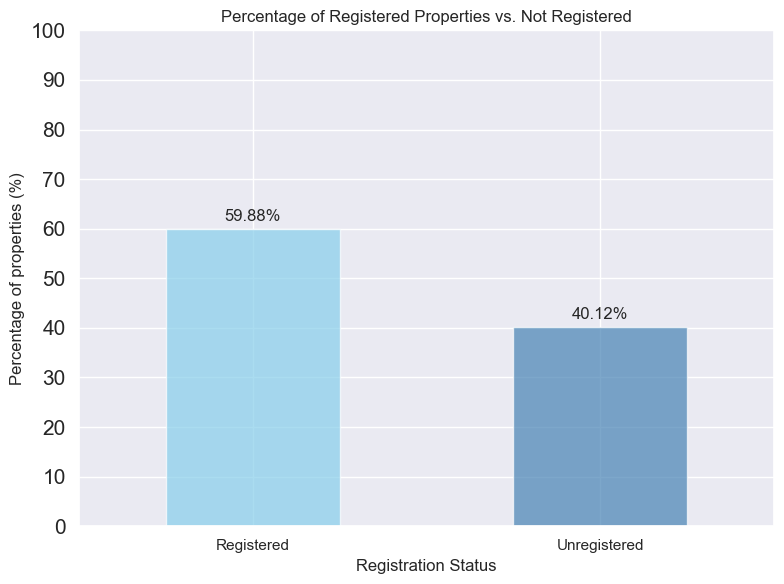

In [67]:
# Contar propiedades registradas y no registradas
license_counts = filtered_listings['license'].isnull().value_counts()

# Calcular porcentajes para propiedades registradas y no registradas
license_counts_percent = license_counts / license_counts.sum() * 100

fig, ax = plt.subplots(figsize=(8, 6))

colors = ['skyblue', 'steelblue']

license_counts_percent.plot(kind='bar', ax=ax, color=colors, alpha=0.7)

ax.set_title('Percentage of Registered Properties vs. Not Registered')
ax.set_xlabel('Registration Status')
ax.set_ylabel('Percentage of properties (%)')
ax.set_xticks([0, 1])
ax.set_xticklabels(['Registered', 'Unregistered'], rotation=0)
ax.set_yticks(range(0, 101, 10))

# Anotar los valores en las barras
for i, v in enumerate(license_counts_percent):
    ax.text(i, v + 1, f'{v:.2f}%', ha='center', va='bottom', fontsize=12)

plt.tick_params(axis='y', which='major', labelsize=15)
plt.tight_layout()
plt.show()


## 3.2 Relación entre el precio medio y el número medio de reseñas por vecindario

Ya que no tenemos datos sobre el Impacto en el mercado de viviendas, realizamos un cálculo sobre la relación entre el precio medio y el número medio de reseñas por vecindario.

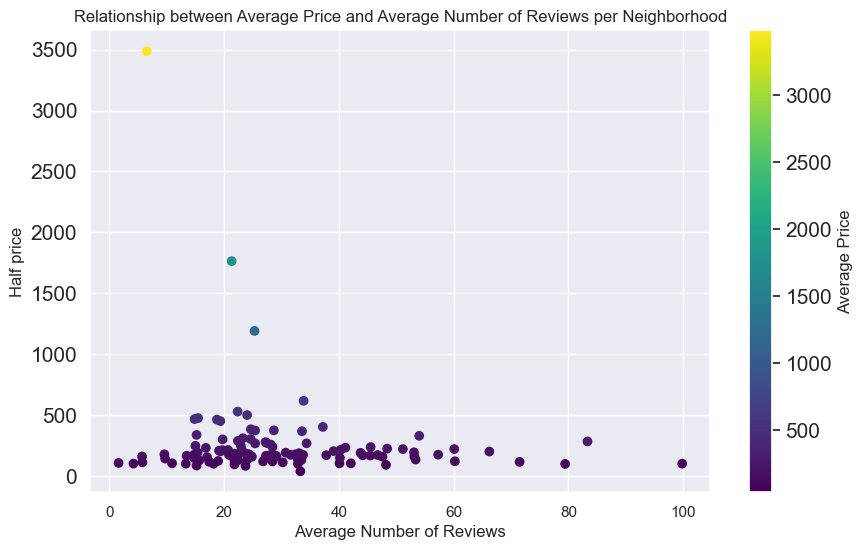

In [68]:
neighbourhood_data = filtered_listings.groupby('neighbourhood_x').agg({'price_y': 'mean', 'number_of_reviews': 'mean'})

plt.figure(figsize=(10, 6))

# Usamos el precio medio como referencia para el color, con una paleta de colores
colors = neighbourhood_data['price_y']

plt.scatter(neighbourhood_data['number_of_reviews'], neighbourhood_data['price_y'], c=colors, cmap='viridis')

# Añadimos una barra de color para entender la escala de colores
cbar = plt.colorbar(label='Average Price')
cbar.ax.tick_params(labelsize=15)

plt.title('Relationship between Average Price and Average Number of Reviews per Neighborhood')
plt.xlabel('Average Number of Reviews')
plt.ylabel('Half price')

plt.tick_params(axis='y', which='major', labelsize=15)
plt.show()


Como podemos observar, la inmensa mayoría de puntos se concentran en el extremo inferior izquierdo del gráfico, lo que nos indica que muchos vecindarios tienen un número bajo de reseñas promedio y precios bajos.

Hay algunos puntos aislados que muestran precios medios mucho más altos, pero estos no parecen correlacionarse con un mayor número de reseñas. De hecho, el vecindario con el precio medio más alto tiene un número de reseñas promedio relativamente bajo.

## 3.3 Perfil de anfitriones

Comprobamos el perfil de los anfitriones y revisamos si son profesionales o no. Esto lo hacemos mediante los datos de la columna "is_professional".

In [69]:
# Idenficiar anfitriones profesionales
professional_hosts = listings[listings['calculated_host_listings_count'] > 10]

professional_hosts['is_professional'] = professional_hosts['host_about'].apply(
    lambda x: 'team' in str(x).lower() or 'company' in str(x).lower()
)

columns_to_print = ['id', 'host_id', 'host_about', 'is_professional']
columns_available = [col for col in columns_to_print if col in professional_hosts.columns]

print("Potential professional hosts:")
professional_hosts[columns_available]


Potential professional hosts:


host_id  \
id                               
43318                    57161   
135608                   57161   
164946                   57161   
229799                 3392276   
288038                 1497543   
...                        ...   
1037466155482103864  221893775   
1037494589212353675  221893775   
1037575019510875191   72933825   
1036569671313140717  414420881   
1036598124607548033  521839237   

                                                            host_about  \
id                                                                       
43318                                          Love to travel and eat!   
135608                                         Love to travel and eat!   
164946                                         Love to travel and eat!   
229799               I am a people person, love to help anyone, in ...   
288038               Gramercy Place is a laid back environment with...   
...                                                                ...   
1037466155482103864  Born and raised in LA. Family operated propert...   
1037494589212353675  Born and raised in LA. Family operated propert...   
1037575019510875191  \nThe Maimon Group is a family owned Luxury Pr...   
1036569671313140717                                                NaN   
1036598124607548033                                                NaN   

                     is_professional  
id                                    
43318                          False  
135608                         False  
164946                         False  
229799                         False  
288038                         False  
...                              ...  
1037466155482103864             True  
1037494589212353675             True  
1037575019510875191             True  
1036569671313140717            False  
1036598124607548033            False  

[11153 rows x 3 columns]

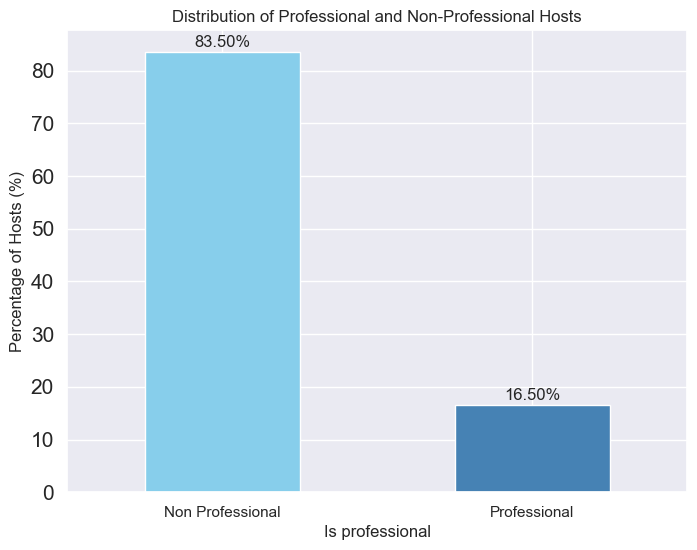

In [70]:
professional_count = professional_hosts['is_professional'].value_counts()

hosts_counts_percent = professional_count / professional_count.sum() * 100


plt.figure(figsize=(8, 6))

colors = ['skyblue', 'steelblue']

ax = hosts_counts_percent.plot(kind='bar', color=colors)

plt.title('Distribution of Professional and Non-Professional Hosts')
plt.xlabel('Is professional')
plt.ylabel('Percentage of Hosts (%)')
plt.xticks(ticks=[0, 1], labels=['Non Professional', 'Professional'], rotation=0)
plt.tick_params(axis='y', which='major', labelsize=15)

# Añadir los porcentajes encima de las barras
for i, value in enumerate(hosts_counts_percent):
    plt.text(i, value + 1, f"{value:.2f}%", ha='center')


plt.show()


# 4. Recomendaciones al turismo

## 4.1 Precio medio por vecindario

Comprobamos el precio medio diario para un alojamiento de 2 personas (ya que hemos visto que era el más común) y como podemos observar, las zonas más famosas de Los Ángeles son las que tienen precios más elevados.

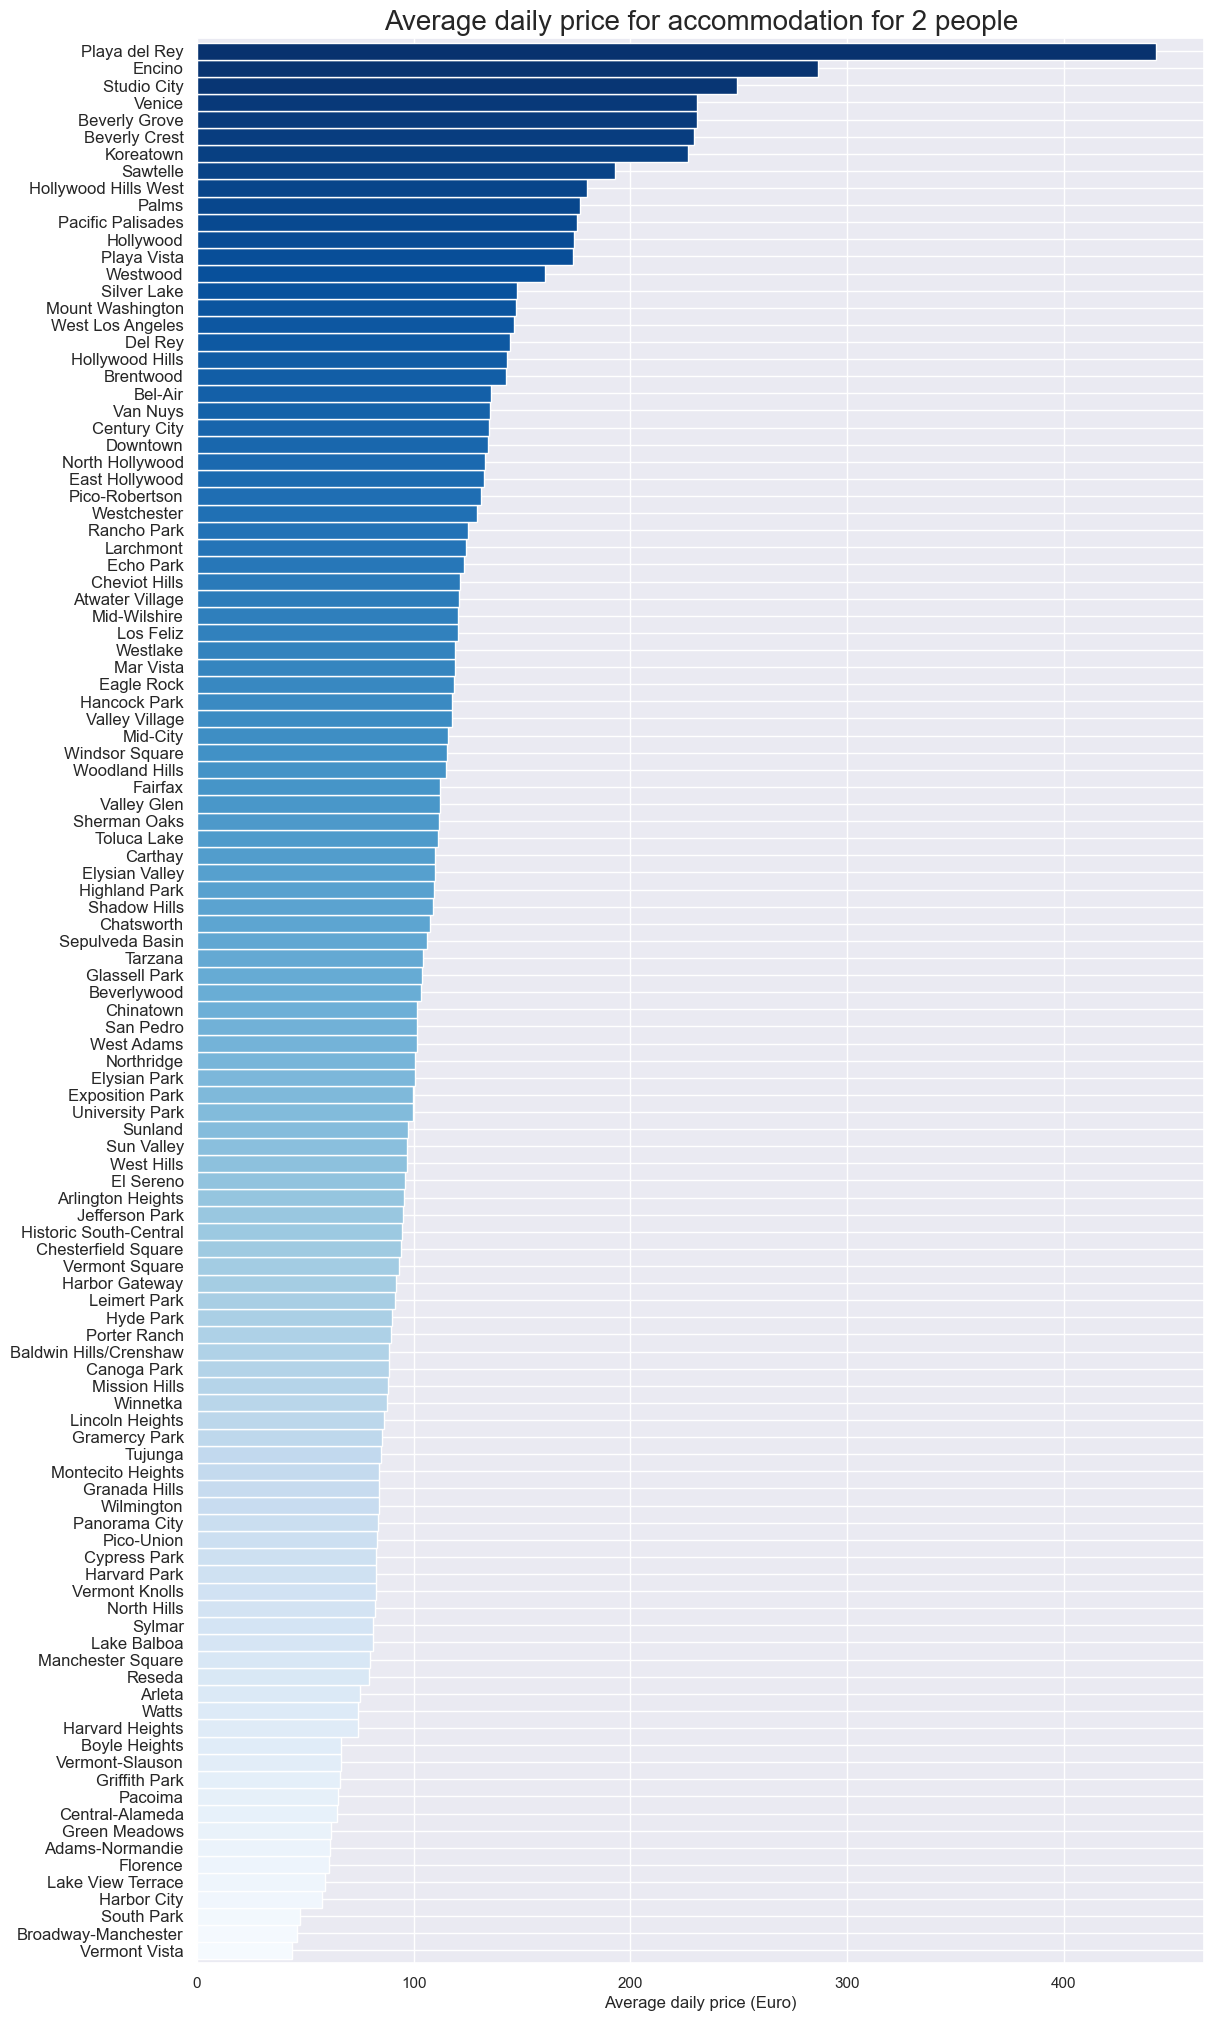

In [71]:
feq = filtered_listings[filtered_listings['accommodates']==2]
feq = feq.groupby('neighbourhood_x')['price_y'].mean().sort_values(ascending=True)

plt.figure(figsize=(13, 25))

colors = sns.color_palette('Blues', len(feq))

feq.plot.barh(width=1, color=colors)

plt.title("Average daily price for accommodation for 2 people", fontsize=20)
plt.xlabel('Average daily price (Euro)', fontsize=12)

plt.ylabel("")

plt.tick_params(axis='y', which='major', labelsize=12)

plt.show()


Podemos observar los barrios en el siguiente mapa interactivo. Al pasar el cursor sobre los polígonos se muestra el nombre del barrio y el precio medio de los alojamientos para 2 personas.

In [72]:
feq_map = feq.reset_index()  # Esto convierte la Series en un DataFrame
feq_map.rename(columns={'price_y': 'average_price'}, inplace=True)
feq_map['average_price'] = feq_map['average_price'].round(decimals=0)

In [73]:
angeles = gpd.read_file("C:/Users/David/Desktop/upgrade_python/temario_bootcamp/Modulo2/Proyecto-Modulo2/airbnb-los_angeles/datasets/neighbourhoods.geojson")
angeles = pd.merge(angeles, feq_map, left_on='neighbourhood', right_on='neighbourhood_x', how='left')
feq_map.rename(columns={'price_y': 'average_price'}, inplace=True)
feq_map.average_price = feq_map.average_price.round(decimals=0)

map_dict = angeles.set_index('neighbourhood_x')['average_price'].to_dict()

# Obtener los valores de umbral ordenados
thresholds_cleaned = sorted([x for x in map_dict.values() if not np.isnan(x)])

# Crear la escala de colores
color_scale = LinearColormap(['yellow', 'red'], vmin=min(thresholds_cleaned), vmax=max(thresholds_cleaned))


def get_color(feature):
    value = map_dict.get(feature['properties']['neighbourhood_x'])
    if value is not None:
        return color_scale(value)
    else:
        # Devuelve un color predeterminado o maneja los valores None de acuerdo a tus necesidades
        return 'gray'  # Puedes cambiar 'gray' por el color que desees para valores None

map3 = folium.Map(location=[34.0522, -118.2437], zoom_start=11.5)
folium.GeoJson(data=angeles,
               name='Los Angeles',
               tooltip=folium.features.GeoJsonTooltip(fields=['neighbourhood_x', 'average_price'],
                                                      labels=True,
                                                      sticky=False),
               style_function= lambda feature: {
                   'fillColor': get_color(feature),
                   'color': 'black',
                   'weight': 1,
                   'dashArray': '5, 5',
                   'fillOpacity':0.5
                   },
               highlight_function=lambda feature: {'weight':3, 'fillColor': get_color(feature), 'fillOpacity': 0.8}).add_to(map3)

color_scale.add_to(map3)

map3

## 4.2 Seguridad en el vecindario

En los archivos de airbnb no tenemos datos sobre la seguridad de los vecindarios. Pero haciendo una pequeña búsqueda por internet, rápidamente podemos encontrar un mapa que representa las zonas más peligrosas y más seguras en Los Ángeles

<center><img src="safety_map.jpg"></center>

## 4.3 Puntuación de las reviews por localización y precio medio diario para 2 personas vs precio

Comprobamos los puntajes de revisión de la ubicación por vecindario con almenos 10 revisiones y con un puntaje mayor o igual a 4.5.

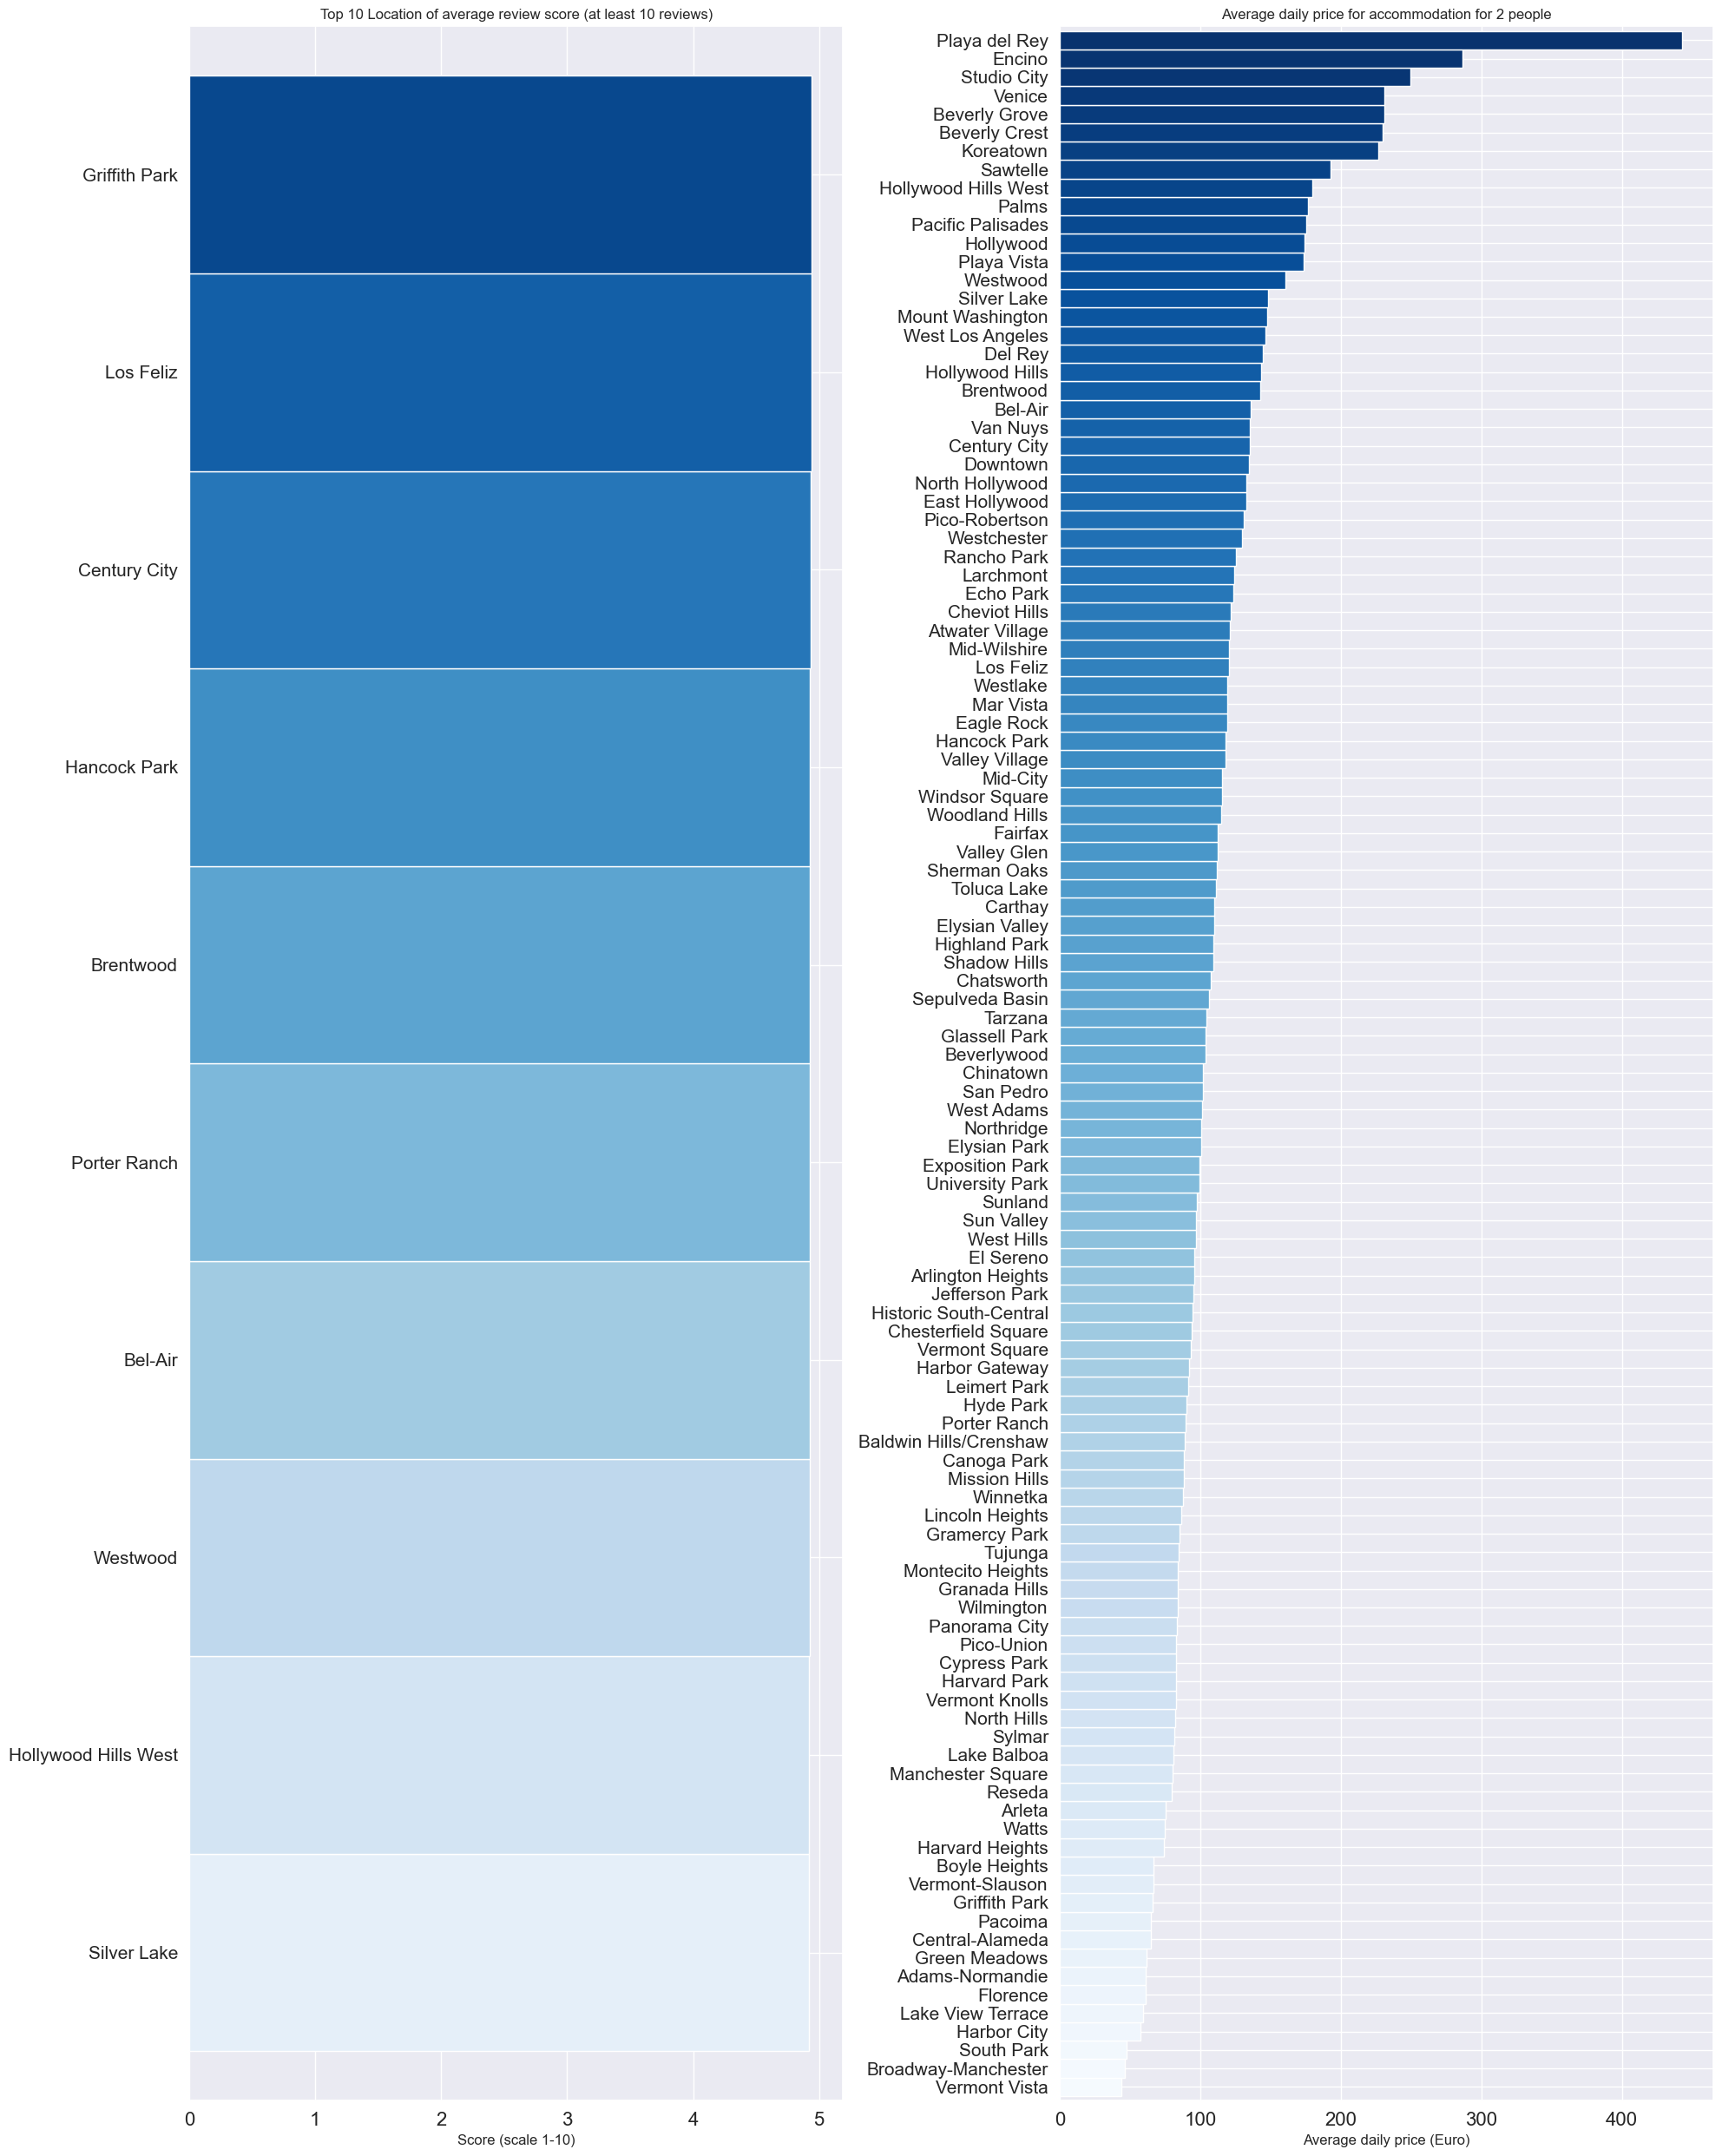

In [74]:
import matplotlib.pyplot as plt
import seaborn as sns

fig = plt.figure(figsize=(20,25))
plt.rc('xtick', labelsize=16)
plt.rc('ytick', labelsize=20)

ax1 = fig.add_subplot(121)
feq = filtered_listings[(filtered_listings['number_of_reviews'] >= 10)]
feq1 = feq.groupby('neighbourhood_x')['review_scores_location'].mean().sort_values(ascending=True)

top_10_scores = feq1[(feq1 >= 4.5) & (feq1 <= 5)].tail(10)

# Usar una paleta de azules
colors_blues = sns.color_palette("Blues", n_colors=10)  # Obtener 10 colores de la paleta Blues
top_10_scores.plot(kind='barh', color=colors_blues, width=1)  # Aplicar la paleta a la gráfica
ax1.set_title("Top 10 Location of average review score (at least 10 reviews)")
ax1.set_xlabel('Score (scale 1-10)')
ax1.set_ylabel('')
plt.tick_params(axis='y', which='major', labelsize=15)

ax2 = fig.add_subplot(122)
feq = filtered_listings[filtered_listings['accommodates']==2]
feq2 = feq.groupby('neighbourhood_x')['price_y'].mean().sort_values(ascending=True)

# Usar la paleta de azules con un número de colores igual al número de barras
colors_blues = sns.color_palette("Blues", n_colors=len(feq2))
feq2.plot(kind='barh', color=colors_blues, width=1)
ax2.set_title("Average daily price for accommodation for 2 people")
ax2.set_xlabel('Average daily price (Euro)')
ax2.set_ylabel('')

plt.tick_params(axis='y', which='major', labelsize=15)

plt.tight_layout()
plt.show()


En el gráfico que muestra el puntaje promedio de revisión de la ubicación para Los Ángeles, se observa que hay una pequeña variación en la puntuación media por barrio, poco significativa.

Esta pequeña variedad de puntuaciones en diferentes barrios, puede reflejar la diversidad y el tamaño de la ciudad. Los Ángeles es extensa y sus barrios pueden variar mucho en términos de ambiente, acceso y servicios.

Como hemos visto ningún barrio tiene un promedio de puntuación de ubicación por debajo de un umbral decentemente alto, lo que podría sugerir que incluso los barrios menos céntricos de Los Ángeles son considerados aceptables en términos de ubicación.

Para los viajeros que buscan un alojamiento en Los Ángeles, podría ser una buena idea considerar opciones fuera de los barrios más caros o de moda, siempre que el barrio sea seguro y tenga buenas conexiones de transporte. Las diferencias en las puntuaciones de ubicación entre los barrios mejor calificados y los más periféricos no parecen ser drásticas, lo que sugiere que hay muchas opciones viables en toda la ciudad.

Como consejo para los turistas, sería conveniente buscar en lugares como Griffith Park, con una gran cantidad de reseñas y una alta puntuación, siendo uno de los lugares con un precio medio menor al resto.

## 4.4 Puntuaciones de las opiniones

Los invitados pueden enviar una calificación de estrellas general y un conjunto de calificaciones de estrellas de categoría, además de las reseñas escritas. Algunas de las caracterísitcas que pueden calificar los huéspedes son:

* Experiencia general. ¿Cuál fue su experiencia en general?
* Limpieza. ¿Sentiste que tu espacio estaba limpio y ordenado?
* Precisión. ¿Con qué precisión su página de listado representó su espacio?
* Valor. ¿Sintió que su listado proporcionó un buen valor por el precio?
* Comunicación. ¿Qué tan bien se comunicó con su anfitrión antes y durante su estadía?
* Llegada. ¿Qué tan bien fue su registro?
* Ubicación. ¿Cómo te sentiste en el barrio?

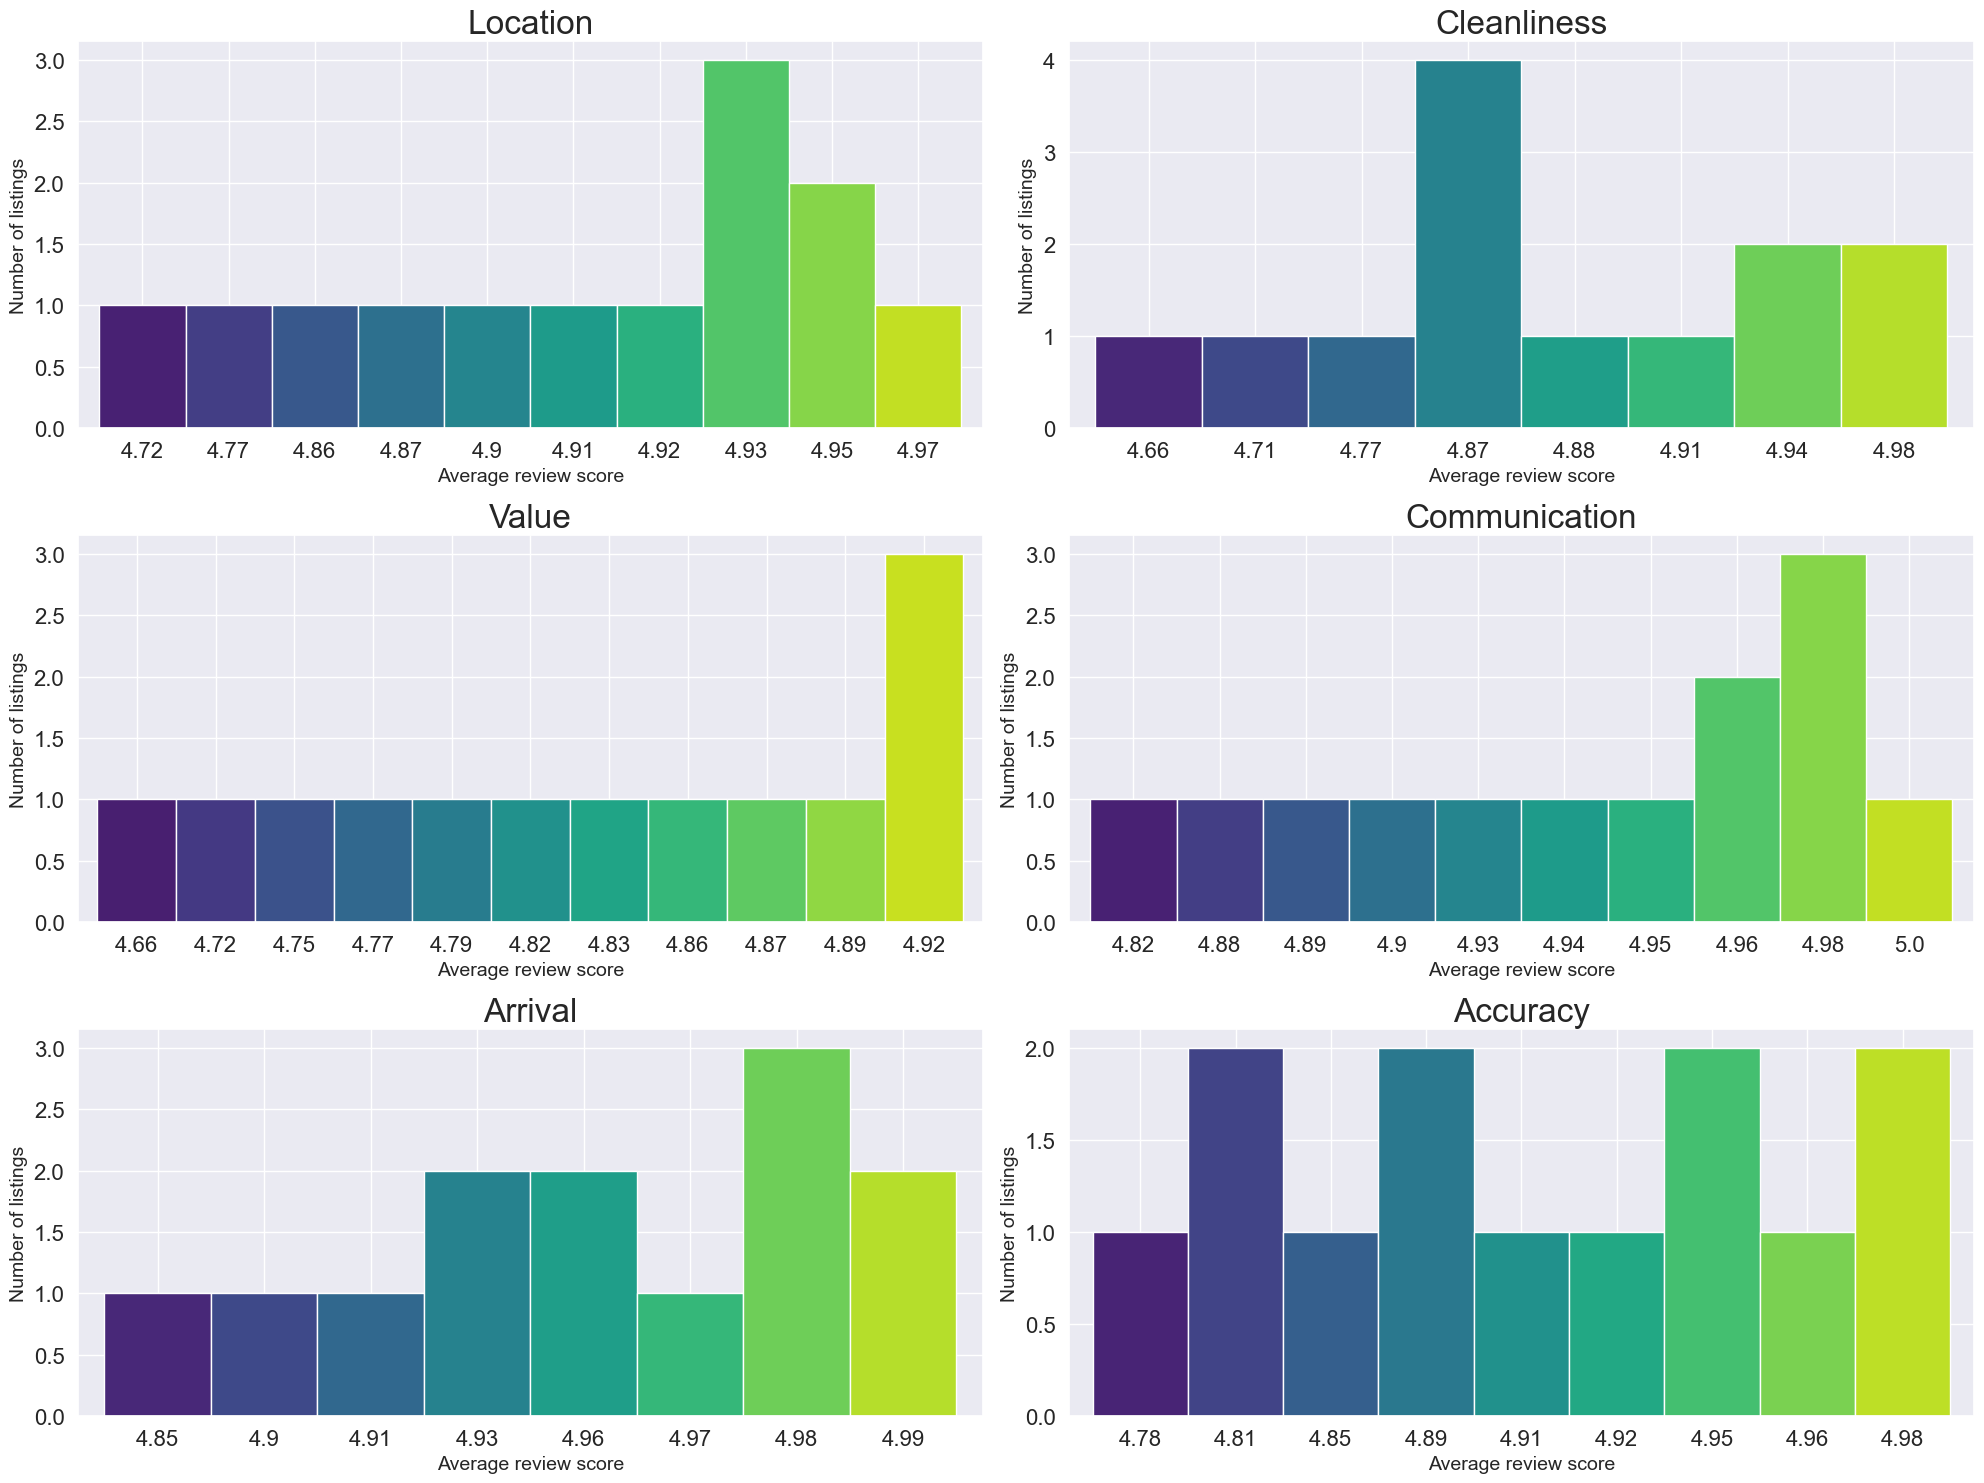

In [75]:
filtered_listings10 = filtered_listings[filtered_listings['number_of_reviews'] >= 650]

fig = plt.figure(figsize=(20, 15))
plt.rc('xtick', labelsize=16) 
plt.rc('ytick', labelsize=16)

# Creamos una función para calcular la paleta correcta
def calculate_viridis_palette(series):
    unique_values = series.value_counts().sort_index()
    palette = sns.color_palette("viridis", n_colors=unique_values.shape[0])
    return unique_values, palette

ax1 = fig.add_subplot(321)
feq, palette = calculate_viridis_palette(filtered_listings10['review_scores_location'])
feq.plot(kind='bar', color=palette, width=1, rot=0)
plt.title("Location", fontsize=24)
plt.ylabel('Number of listings', fontsize=14)
plt.xlabel('Average review score', fontsize=14)

ax2 = fig.add_subplot(322)
feq, palette = calculate_viridis_palette(filtered_listings10['review_scores_cleanliness'])
feq.plot(kind='bar', color=palette, width=1, rot=0)
plt.title("Cleanliness", fontsize=24)
plt.ylabel('Number of listings', fontsize=14)
plt.xlabel('Average review score', fontsize=14)

ax3 = fig.add_subplot(323)
feq = filtered_listings10['review_scores_value'].value_counts().sort_index()
feq, palette = calculate_viridis_palette(filtered_listings10['review_scores_value'])
feq.plot(kind='bar', color=palette, width=1, rot=0)
plt.title("Value", fontsize=24)
plt.ylabel('Number of listings', fontsize=14)
plt.xlabel('Average review score', fontsize=14)

ax4 = fig.add_subplot(324)
feq = filtered_listings10['review_scores_communication'].value_counts().sort_index()
feq, palette = calculate_viridis_palette(filtered_listings10['review_scores_communication'])
feq.plot(kind='bar', color=palette, width=1, rot=0)
plt.title("Communication", fontsize=24)
plt.ylabel('Number of listings', fontsize=14)
plt.xlabel('Average review score', fontsize=14)

ax5 = fig.add_subplot(325)
feq = filtered_listings10['review_scores_checkin'].value_counts().sort_index()
feq, palette = calculate_viridis_palette(filtered_listings10['review_scores_checkin'])
feq.plot(kind='bar', color=palette, width=1, rot=0)
plt.title("Arrival", fontsize=24)
plt.ylabel('Number of listings', fontsize=14)
plt.xlabel('Average review score', fontsize=14)

ax6 = fig.add_subplot(326)
feq = filtered_listings10['review_scores_accuracy'].value_counts().sort_index()
feq, palette = calculate_viridis_palette(filtered_listings10['review_scores_accuracy'])
feq.plot(kind='bar', color=palette, width=1, rot=0)
plt.title("Accuracy", fontsize=24)
plt.ylabel('Number of listings', fontsize=14)
plt.xlabel('Average review score', fontsize=14)

plt.tight_layout()
plt.show()


Revisando las calificaciones, observamos como todas son realmente altas. Esto está explicado en el siguiente artículo: [¿Más alta que la calificación promedio? El 95 % de los listados de Airbnb calificaron de 4,5 a 5 estrellas](https://mashable.com/2015/02/25/airbnb-reviews-above-average/?europe=true#1YLfzOC34sqd).

Tras revisar las distribuciones de los puntajes, podemos considerar que cualquier puntaje por debajo de 4 no es un buen puntaje.

## 4.5 Encontrando un buen hospedador

En Airbnb puedes obtener el estatus de "Superhost". De Airbnb:
* Como SuperAnfitrión, tendrá más visibilidad, potencial de ingresos y recompensas exclusivas. Es nuestra manera de decir gracias por su hospitalidad excepcional.
* Cómo convertirse en Superhost: cada 3 meses, verificamos si cumple con los siguientes criterios. Si lo haces, ganarás o mantendrás tu estatus de SuperAnfitrión.
    * Los Superanfitriones tienen una calificación general promedio de 4.8 o superior según las reseñas de al menos el 50 % de sus huéspedes de Airbnb durante el último año.
    * Los Superhosts han alojado al menos 10 estadías en el último año o, si realizan reservas a más largo plazo, 100 noches en al menos 3 estadías.
    * Los Superhosts no tienen cancelaciones en el último año, a menos que haya circunstancias atenuantes.
    * Los Superhosts responden al 90 % de los mensajes nuevos en 24 horas.

A continuación, podemos ver que solo una pequeña parte de los listados en Los Ángeles tienen un anfitrión que es Superanfitrión.

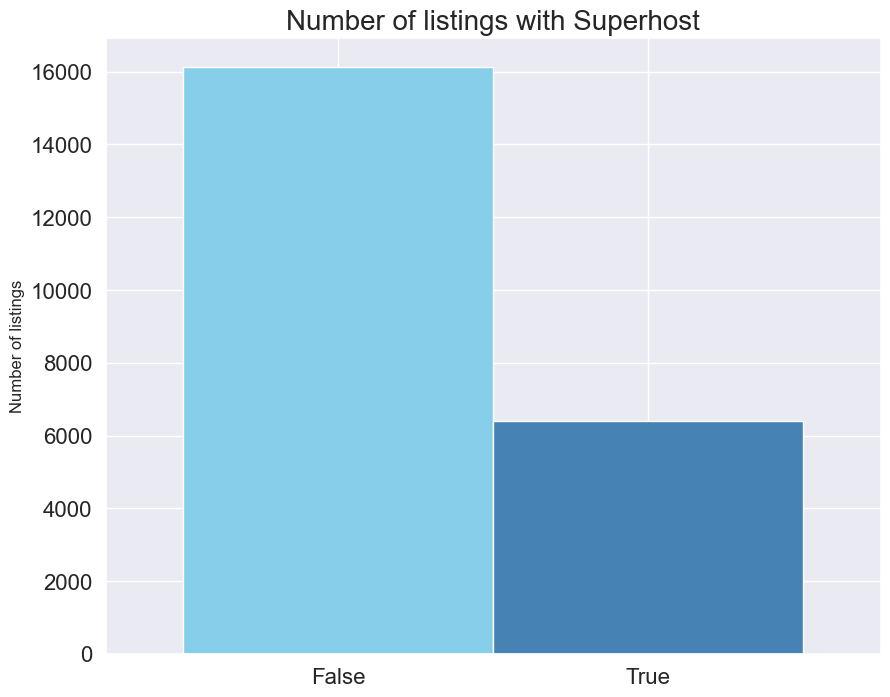

In [76]:
filtered_listings.host_is_superhost = filtered_listings.host_is_superhost.replace({"t": "True", "f": "False"})

colors = ['skyblue', 'steelblue']

feq=filtered_listings['host_is_superhost'].value_counts()
feq.plot.bar(figsize=(10, 8), color=colors, width=1, rot=0)
plt.title("Number of listings with Superhost", fontsize=20)
plt.ylabel('Number of listings', fontsize=12)
plt.show()

Normalmente, que el host sea un superhost no es algo que se suela tener en cuenta frente a otros requisitos, ya que probablemente el superhost aumentará los precios. Pero tampoco buscamos un host que tenga malas reseñas, responda mal o realice demasiadas cancelaciones.

Como podemos ver, más de 5000 listados tienen al menos 10 reseñas y responden al menos al 90% de los mensajes nuevos. Podemos considerar que estos anfitriones son buenos respondiendo. Además, hay muy pocos listados con anfitriones que no respondan a los mensajes nuevos dentro de las 24 horas.

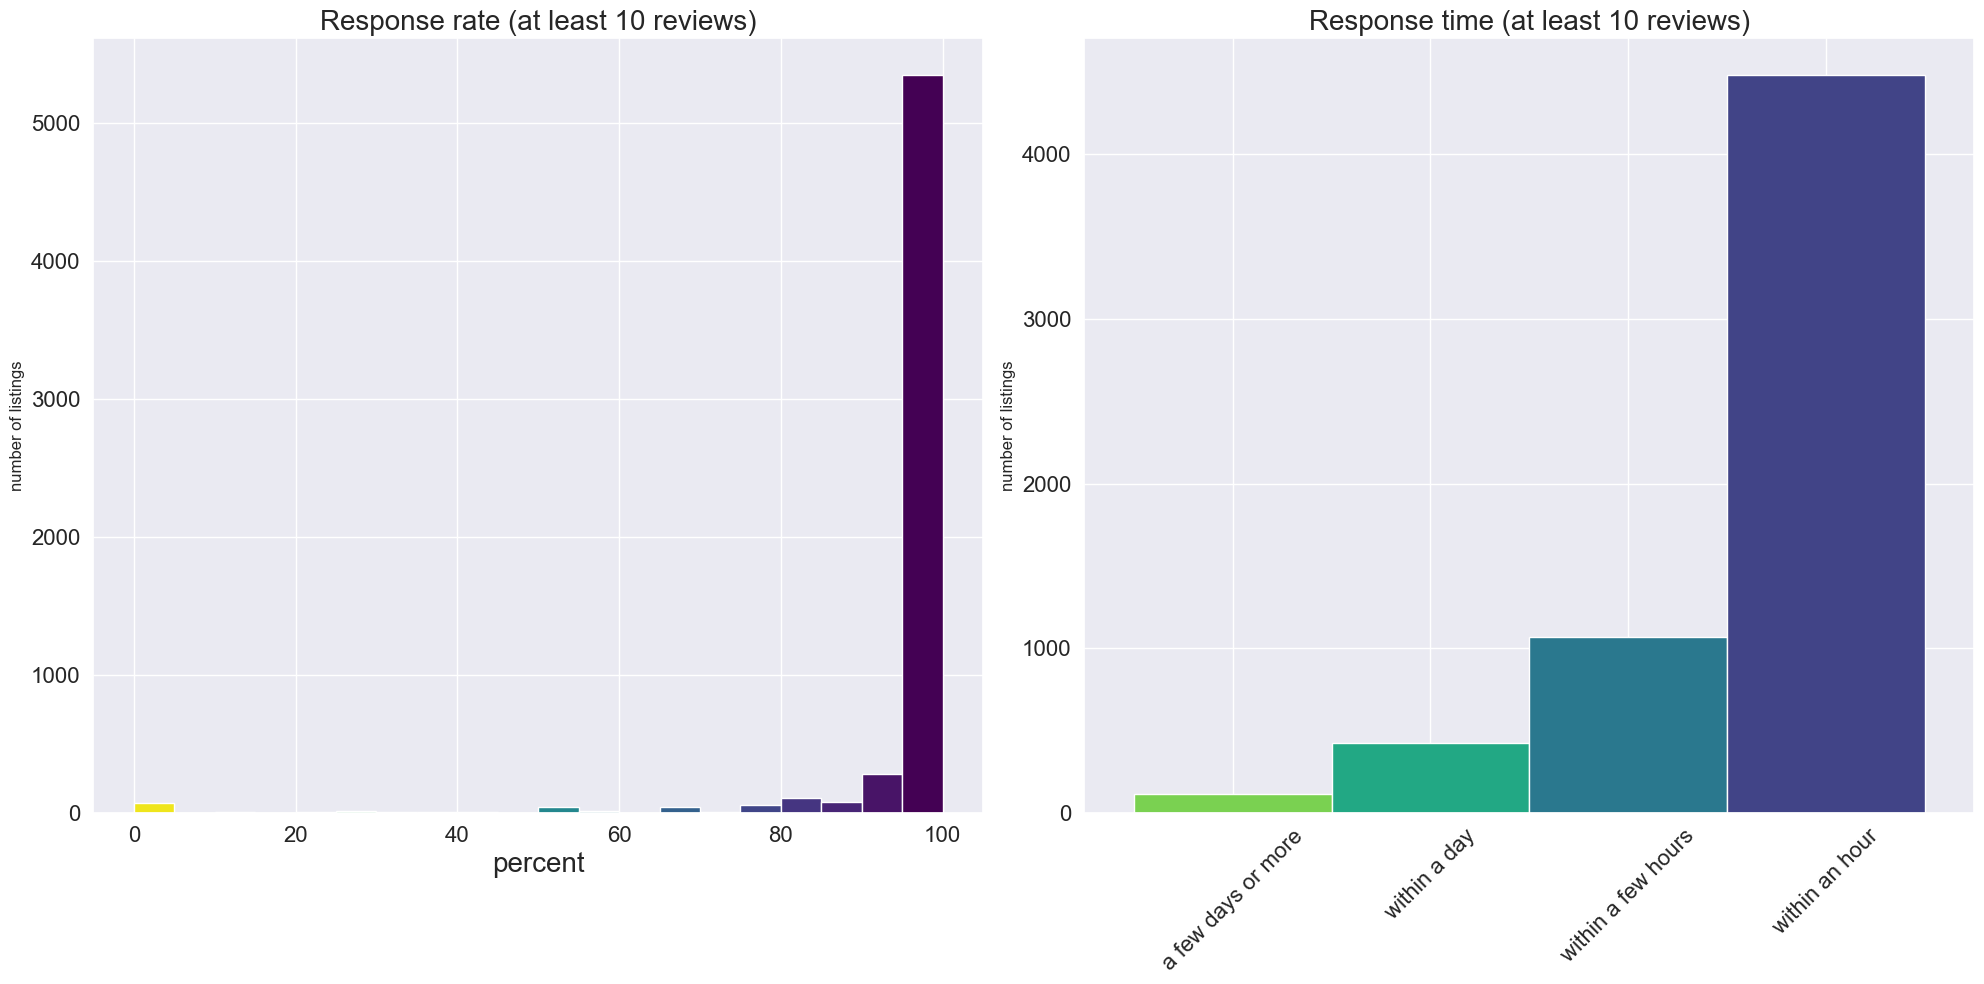

In [77]:
filtered_listings10 = filtered_listings[filtered_listings['number_of_reviews'] >= 10]
filtered_listings10['host_response_rate'] = filtered_listings10['host_response_rate'].str.rstrip('%').astype('float') / 100

fig = plt.figure(figsize=(20, 10))
plt.rc('xtick', labelsize=16) 
plt.rc('ytick', labelsize=16)

# Histograma para la tasa de respuesta
ax1 = fig.add_subplot(121)
feq1 = filtered_listings10['host_response_rate'].dropna()

# Creamos el histograma sin color específico para obtener las barras
n_bins = 20
counts, bins, patches = ax1.hist(feq1, bins=n_bins)

# Coloreamos cada barra con un color de la paleta 'viridis'
bin_centers = 0.5 * (bins[:-1] + bins[1:])
colormap = plt.cm.viridis.reversed()  # Usamos la paleta 'viridis'
for count, patch, center in zip(counts, patches, bin_centers):
    # Escalamos cada color para que coincida con la altura de la barra
    color = colormap(center / max(bin_centers))
    patch.set_facecolor(color)

plt.title("Response rate (at least 10 reviews)", fontsize=20)
plt.ylabel("number of listings")
plt.xlabel("percent", fontsize=20)

# Ajustamos los ticks del eje x para mostrar porcentajes
ax1.xaxis.set_major_formatter(plt.FuncFormatter(lambda x, _: f'{int(x*100)}'))

# Gráfico de barras para el tiempo de respuesta
ax2 = fig.add_subplot(122)
feq2 = filtered_listings10['host_response_time'].value_counts().sort_index()
palette = sns.color_palette("viridis_r", len(feq2))
ax2 = feq2.plot.bar(color=palette, width=1, rot=45)
plt.title("Response time (at least 10 reviews)", fontsize=20)
plt.ylabel("number of listings")

plt.tight_layout()
plt.show()


Por lo que vemos en los gráficos, no parece que sea superhost para que te respondan en el mismo día ni nada por el estilo.

## 4.6 Disponibilidad en el tiempo 

El archivo de calendario contiene 365 registros para cada listado, lo que significa que para cada listado, el precio y la disponibilidad por fecha se especifican con 365 días de anticipación.

In [78]:
calendar = calendar[calendar.date > '2024-01-25']

In [79]:
print(calendar.shape)

(14238820, 6)


In [80]:
calendar.tail()

date available price adjusted_price  minimum_nights  \
listing_id                                                                      
1036598124607548033 2024-11-29         f   NaN            NaN             3.0   
1036598124607548033 2024-11-30         f   NaN            NaN             3.0   
1036598124607548033 2024-12-01         f   NaN            NaN             3.0   
1036598124607548033 2024-12-02         f   NaN            NaN             3.0   
1036598124607548033 2024-12-03         f   NaN            NaN             3.0   

                     maximum_nights  
listing_id                           
1036598124607548033           365.0  
1036598124607548033           365.0  
1036598124607548033           365.0  
1036598124607548033           365.0  
1036598124607548033           365.0

A continuación se muestra un ejemplo de los datos del calendario. Importante tener en cuenta: la disponibilidad es FALSE significa que el propietario no quiere alquilar su propiedad en la fecha específica o que la lista ya se ha reservado para esa fecha. Fusionamos la variable 'acomodate' con el calendario para compararlo con los precios.

In [81]:
filtered_listings.index.name = "listing_id"
calendar = pd.merge(calendar, filtered_listings[['accommodates']], on = "listing_id", how = "left")
calendar.sample(15)

date available price adjusted_price  minimum_nights  \
listing_id                                                                      
630354634976393798  2024-08-04         f   NaN            NaN             2.0   
41096342            2024-08-10         t   NaN            NaN             3.0   
944648743910610708  2024-07-04         t   NaN            NaN             1.0   
53063787            2024-06-10         f   NaN            NaN             7.0   
954811376975341079  2024-12-02         f   NaN            NaN            30.0   
46526700            2024-05-23         f   NaN            NaN             2.0   
11893143            2024-04-23         f   NaN            NaN            30.0   
990768510919219339  2024-07-07         f   NaN            NaN             1.0   
789069158803646082  2024-06-12         f   NaN            NaN            31.0   
787794972156434630  2024-02-29         f   NaN            NaN             2.0   
19246990            2024-11-15         f   NaN            NaN             3.0   
45895943            2024-05-29         f   NaN            NaN            31.0   
896392375309502623  2024-03-10         t   NaN            NaN            30.0   
1027015974845400233 2024-07-26         t   NaN            NaN            30.0   
39081964            2024-04-07         t   NaN            NaN             2.0   

                     maximum_nights  accommodates  
listing_id                                         
630354634976393798             30.0           NaN  
41096342                     1125.0           NaN  
944648743910610708            365.0           NaN  
53063787                       31.0           NaN  
954811376975341079            365.0           1.0  
46526700                       27.0          10.0  
11893143                     1125.0           1.0  
990768510919219339            365.0           NaN  
789069158803646082            365.0           NaN  
787794972156434630             90.0          16.0  
19246990                     1125.0           NaN  
45895943                       90.0           2.0  
896392375309502623            365.0           4.0  
1027015974845400233           365.0           NaN  
39081964                       30.0          16.0

A continuación, vemos que hasta tres meses por delante, generalmente hay más alojamientos disponibles que en el futuro. Las razones de esto pueden ser que los anfitriones están actualizando más activamente sus calendarios en este período de tiempo. Este gráfico muestra información sobre el "número de listados disponibles" y el "día de la semana" por fecha.

In [82]:
sum_available = calendar[calendar.available == "t"].groupby(['date']).size().to_frame(name= 'available').reset_index()
sum_available['weekday'] = sum_available['date'].dt.day_name()
sum_available = sum_available.set_index('date')

sum_available.iplot(y='available', mode = 'lines', xTitle = 'Date', yTitle = 'number of listings available',\
                   text='weekday', title = 'Number of listings available by date')

Vemos pequeños picos en los fines de semana, lo cual es normal ya que los fines de semana suelen haber menos casas libres.

# 5. Minería de texto con las _reviews_


Veamos a obtener algo de información extra de las opiniones de los usuarios, en términos muy elementales. Esta sección es un preliminar muy introductorio y básico de un amplio área de estudio conocida como *topic modelling*.

El archivo de "reviews" resultó no ser muy interesante, ya que solo contiene fechas de revisión para cada listado, lo que significa que solo es bueno para contar el número de revisiones. El archivo "reviews_details" contiene la misma información (y la misma cantidad de registros), con 4 columnas adicionales. Además, fusionamos host_id y host_names de la lista con el archivo reviews_details.

In [83]:
reviews_details.shape

(1528123, 6)

In [84]:
reviews_details = pd.merge(
    reviews_details,
    filtered_listings[['host_id', 'host_name', 'name']],
    left_on="listing_id",
    right_on="host_id",
    how="left"
)
reviews_details = reviews_details.set_index('id')
reviews_details = reviews_details[['listing_id', 'name', 'host_id', 'host_name', 'date', 'reviewer_id', 'reviewer_name', 'comments']]
reviews_details.head()

listing_id name  host_id host_name       date  reviewer_id  \
id                                                                     
449036           109  NaN      NaN       NaN 2011-08-15       927861   
74506539         109  NaN      NaN       NaN 2016-05-15     22509885   
13994902        2708  NaN      NaN       NaN 2014-06-09     10905424   
14606598        2708  NaN      NaN       NaN 2014-06-23      2247288   
39597339        2708  NaN      NaN       NaN 2015-07-25     27974696   

         reviewer_name                                           comments  
id                                                                         
449036           Edwin  The host canceled my reservation the day befor...  
74506539          Jenn  Me and two friends stayed for four and a half ...  
13994902       Kuberan  i had a wonderful stay. Everything from start ...  
14606598       Camilla  Charles is just amazing and he made my stay sp...  
39597339        Fallon  Staying with Chas was an absolute pleasure. He...

In [85]:
reviews_details.columns

Index(['listing_id', 'name', 'host_id', 'host_name', 'date', 'reviewer_id',
       'reviewer_name', 'comments'],
      dtype='object')

Revisamos los 5 hosts con más reseñas.

In [86]:
host_reviews = reviews_details.groupby(['host_id', 'host_name']).size().sort_values(ascending=False).to_frame(name = "number_of_reviews")
host_reviews.head()

number_of_reviews
host_id    host_name                   
52897131.0 Brianna                   86

In [87]:
reviews_details.comments.head()

id
449036      The host canceled my reservation the day befor...
74506539    Me and two friends stayed for four and a half ...
13994902    i had a wonderful stay. Everything from start ...
14606598    Charles is just amazing and he made my stay sp...
39597339    Staying with Chas was an absolute pleasure. He...
Name: comments, dtype: object

In [88]:
reviews_details.comments.values[2] #print comment with numbers and windows line break

'i had a wonderful stay. Everything from start to the end was perfect.<br/>Will come back again.'

In [89]:
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\David\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

Añadimos ahora algo de preprocesamiento

In [90]:
#take out empty comments (530)
reviews_details = reviews_details[reviews_details['comments'].notnull()]

#remove numbers
reviews_details['comments'] = reviews_details['comments'].str.replace('\d+', '') 
#all to lowercase
reviews_details['comments'] = reviews_details['comments'].str.lower()
#remove windows new line
reviews_details['comments'] = reviews_details['comments'].str.replace('\r\n', "")
#remove stopwords (from nltk library)
stop_english = stopwords.words("english")
reviews_details['comments'] = reviews_details['comments'].apply(lambda x: " ".join([i for i in x.split() 
                                                      if i not in (stop_english)]))
# remove punctuation
reviews_details['comments'] = reviews_details['comments'].str.replace('[^\w\s]'," ")
# replace x spaces by one space
reviews_details['comments'] = reviews_details['comments'].str.replace('\s+', ' ')

reviews_details.comments.values[2] #print same comments again

'wonderful stay everything start end perfect br will come back again '

Implementamos un conteo de palabras y lo empleamos para crear un *wordcloud*

In [91]:
texts = reviews_details.comments.tolist()

vec = CountVectorizer().fit(texts)
bag_of_words = vec.transform(texts)
sum_words = bag_of_words.sum(axis=0)
words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]

cvec_df = pd.DataFrame.from_records(words_freq, columns= ['words', 'counts']).sort_values(by="counts", ascending=False)
cvec_df.head(10)

words  counts
11      great  811109
12      place  792938
13       stay  759037
40         br  448933
68      clean  419083
143  location  402951
267     would  337907
0        host  327723
49       nice  314275
121     house  281432

In [92]:
texts = reviews_details.comments.tolist()

# Preprocesar los textos para eliminar la palabra 'br'
texts = [re.sub(r'\bbr\b', '', text) for text in texts]

vec = CountVectorizer().fit(texts)
bag_of_words = vec.transform(texts)
sum_words = bag_of_words.sum(axis=0)
words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]

cvec_df = pd.DataFrame.from_records(words_freq, columns=['words', 'counts']).sort_values(by="counts", ascending=False)
cvec_df.head(10)


words  counts
11        great  811109
12        place  792938
13         stay  759037
67        clean  419083
142    location  402951
266       would  337907
0          host  327723
48         nice  314275
120       house  281432
36   everything  266156

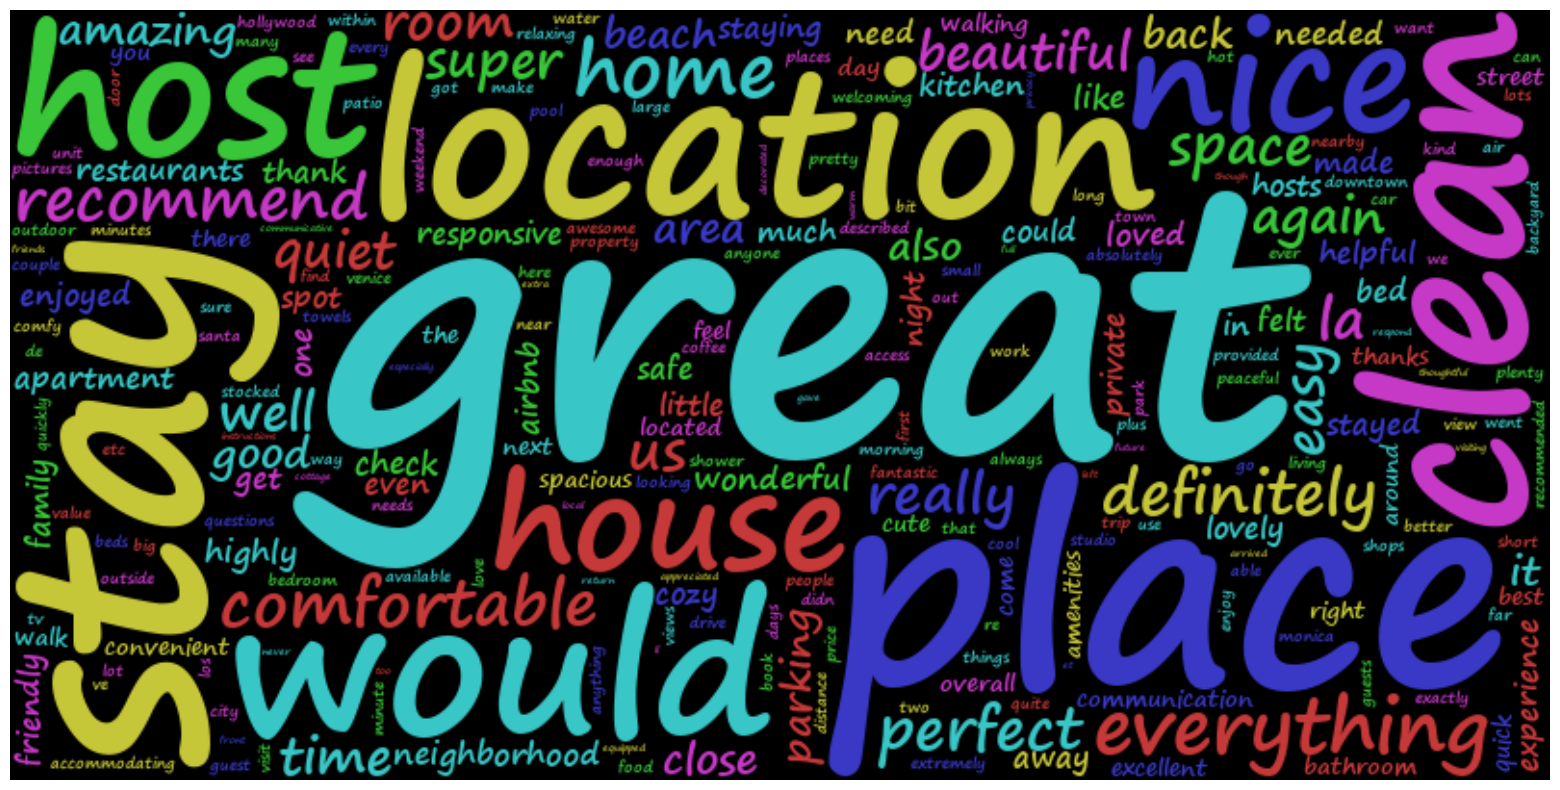

In [97]:
import matplotlib.pyplot as plt
from wordcloud import WordCloud
import random

cvec_dict = dict(zip(cvec_df.words, cvec_df.counts))

# Define una función de color personalizada
def custom_color_func(word, font_size, position, orientation, random_state=None, **kwargs):
    # Reducir la saturación y luminosidad para colores menos intensos
    colors = [
        'hsl(0, 55%, 50%)',   # rojo
        'hsl(120, 55%, 50%)', # verde
        'hsl(240, 55%, 50%)', # azul
        'hsl(60, 55%, 50%)',  # amarillo
        'hsl(180, 55%, 50%)', # cian
        'hsl(300, 55%, 50%)', # magenta
        # ... puedes ajustar la saturación (segundo valor %) y luminosidad (tercer valor %) a tus preferencias
    ]
    return random.choice(colors)  # selecciona un color aleatorio de la lista

# Crear el WordCloud
wordcloud = WordCloud(
    width=800,
    height=400,
    font_path='C:/Windows/Fonts/segoeprb.ttf',  # Especificar el nombre de la fuente
    color_func=custom_color_func,
    background_color='black',
    max_words=250
)

wordcloud.generate_from_frequencies(frequencies=cvec_dict)

# Visualización
plt.figure(figsize=(20, 10))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()
